*ПРИМЕЧАНИЕ:* Рекомендуется начать изучение работы с раздела [Отчет](https://colab.research.google.com/drive/1RSbAgJmlG2P1ks9Sl2trM5HUcEyhEtWf#scrollTo=zG5AEcLNQabm)

# Installs

## Core

In [ ]:
import torch.multiprocessing as mp

# Set the start method to 'spawn' before importing any libraries
mp.set_start_method('spawn', force=True)

In [ ]:
!pip install gdown

In [ ]:
import os
import glob
import gdown
import copy

import math
import numpy as np
from numpy import ma
import pandas as pd

# import torchvision as tv
from torchvision.datasets import CelebA
import torchvision.transforms.v2 as transforms

import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm

GLOBAL_SEED = 2024

In [ ]:
# Default
ROOT_SAVE_DIR = '.'
ROOT_WORK_DIR = '.'

# Optionally load from GDrive
# ROOT_SAVE_DIR = '/content/drive/MyDrive/practice/face-recognition'

## Optional #1

In [ ]:
!pip install -q pytorch-lightning
# !pip install -q lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 30.4 MB/s eta 0:00:00


In [ ]:
!pip install -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import torchmetrics
from torchmetrics import Accuracy

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# import lightning as pl
# from lightning.pytorch.loggers import WandbLogger
# from lightning.pytorch import Trainer
# from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

from torch import optim
from itertools import chain
from torch.optim.lr_scheduler import MultiStepLR

import wandb

pl.seed_everything(GLOBAL_SEED)


INFO:lightning_fabric.utilities.seed:Seed set to 2024


2024

In [ ]:
# import torch

# if torch.cuda.is_available():
#     !pip install faiss-gpu
# else:
#     !pip install faiss-cpu

## Optional #2

In [ ]:
import torch

if torch.cuda.is_available():
    !pip install -q faiss-gpu
else:
    !pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 55.1 MB/s eta 0:00:00


## Optional #3

In [ ]:
%%capture
# import torch
# remove quiet flag -q for debugging
!pip install -q onnx

if torch.cuda.is_available():
    !pip install -q onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
else:
    !pip install -q onnxruntime

# LATEST INSIGHTFACE IN PIP DOES NOT SUPPORT LATEST NUMPY
!pip install -q 'insightface @ git+https://github.com/deepinsight/insightface/#subdirectory=python-package'

In [ ]:
import cv2

import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

from PIL import Image, ImageOps
from matplotlib import pyplot as plt

# Data

## Dataset: CelebA (full)

### Download data


In [ ]:
#@title Activate gdown cookies

# TODO: load with wget
# !wget --load-cookies {quoted(cookies_filepath)} -P {ds_zip_dir} {quoted(ds_meta['link'])}

def get_cookies_filepath(cookies_filename=None, root_dir='.'):
    if cookies_filename is None:
        glob_pattern = os.path.join(root_dir, '*cookies*.txt')
    else:
        glob_pattern = os.path.join(root_dir, cookies_filename + "*")
    cookies_files = glob.glob(glob_pattern)
    if len(cookies_files) > 0:
        return cookies_files[-1]
    else:
        print(f"No '{glob_pattern}' files found in directory '{root_dir}'")
        return None

def activate_gdown_cookies(**kwargs):
    cookies_filepath = get_cookies_filepath(**kwargs)
    if cookies_filepath is not None:
        !cp {quoted(cookies_filepath)} ~/.cache/gdown/cookies.txt
        print("Successfully activated cookies for gdown.")
        print(f"Used file: {cookies_filepath}")

def quoted(s):
    return f"'{s}'"


activate_gdown_cookies()

Successfully activated cookies for gdown.
Used file: ./cookies (6).txt


In [ ]:
#@title Torchvision dataset download

import gdown

def download_tv_dataset(file_list, data_dir, dataset_name):
    ds_data_dir = os.path.join(data_dir, dataset_name)
    if not os.path.isdir(ds_data_dir):
        os.makedirs(ds_data_dir)

    for file_id, md5_hash, file_name in file_list:
        file_path = os.path.join(ds_data_dir, file_name)
        if not os.path.isfile(file_path):
            !gdown "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$file_id' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$file_id" -O {file_path} && rm -rf /tmp/cookies.txt
            if file_path.endswith('.zip'):
                print("Unzipping...")
                !unzip -qq -o {file_path} -d {ds_data_dir}
                print("Done unzipping.")

In [ ]:
celeba_file_list = [
        # File ID                                      MD5 Hash                            Filename
        ("0B7EVK8r0v71pZjFTYXZWM3FlRnM", "00d2c5bc6d35e252742224ab0c1e8fcb", "img_align_celeba.zip"),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc","b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        ("0B7EVK8r0v71pblRyaVFSWGxPY0U", "75e246fa4810816ffd6ee81facbd244c", "list_attr_celeba.txt"),
        ("1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS", "32bd1bd63d3c78cd57e08160ec5ed1e2", "identity_CelebA.txt"),
        ("0B7EVK8r0v71pbThiMVRxWXZ4dU0", "00566efa6fedff7a56946cd1c10f1c16", "list_bbox_celeba.txt"),
        ("0B7EVK8r0v71pd0FJY3Blby1HUTQ", "cc24ecafdb5b50baae59b03474781f8c", "list_landmarks_align_celeba.txt"),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        ("0B7EVK8r0v71pY0NSMzRuSXJEVkk", "d32c9cbf5e040fd4025c592c306e6668", "list_eval_partition.txt"),
    ]

download_tv_dataset(celeba_file_list, 'data', 'celeba')

Downloading...
From (original): https://docs.google.com/uc?export=download&confirm=&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://docs.google.com/uc?export=download&confirm=t&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&uuid=9968331e-ed6a-4cab-af38-ebcba27373a0&at=AEVmpL9fnOjAAOfCpGFRyr_boIPN%3A1725273460840
To: /content/data/celeba/img_align_celeba.zip
100% 1.44G/1.44G [00:19<00:00, 73.2MB/s]
Unzipping...
Done unzipping.
Downloading...
From: https://docs.google.com/uc?export=download&confirm=&id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 127MB/s]
Downloading...
From: https://docs.google.com/uc?export=download&confirm=&id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 85.1MB/s]
Downloading...
From: https://docs.google.com/uc?export=download&confirm=&id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100% 6.08M/6.08M [00:00<00:00, 59.5M

### TODO: Universal dataset download

In [ ]:
DATASETS_LINKS = {
    # 'casia-webface': 'https://drive.google.com/file/d/1KxNCrXzln0lal3N4JiYl9cFOIhT78y1l/view?usp=sharing',

    # 'umd_face': {
    #     'link_type': 'gdrive',
    #     'link': 'https://drive.google.com/file/d/1azhEHoJjVmifuzBVKJwl-sDbLZ-Wzp4O/view',
    # },

    'celeba': {
        'link_type': 'gdrive',
        'link': 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM',
    }
}

In [ ]:
ZIP_DIR = os.path.join(ROOT_SAVE_DIR, 'zip')
DATA_DIR = os.path.join(ROOT_WORK_DIR, 'data')

def download_all():
    for ds_name, ds_meta in DATASETS_LINKS.items():
        ds_zip_dir = os.path.join(ZIP_DIR, ds_name)
        if not os.path.isdir(ds_zip_dir):
            os.makedirs(ds_zip_dir)

        ds_data_dir = os.path.join(DATA_DIR, ds_name)
        if not os.path.isdir(ds_data_dir):
            os.makedirs(ds_data_dir)

        if len(os.listdir(ds_data_dir)) == 0:
            # download if not exists
            pattern = os.path.join(ds_zip_dir, '*.zip')
            ds_zip_files = glob.glob(pattern)
            if len(ds_zip_files) == 1:
                ds_zip_filepath = ds_zip_files[0]
            elif len(ds_zip_files) == 0:
                if ds_meta['link_type'] == 'gdrive':
                    ds_zip_filepath = os.path.join(ds_zip_dir, 'archive.zip')
                    !gdown --fuzzy {ds_meta['link']} -O {ds_zip_filepath}
                elif ds_meta['link_type'] == 'kaggle':
                    !kaggle datasets download -d {ds_meta['link']} --path {ds_zip_filepath}
            elif len(ds_zip_files) > 1:
                print(f"ERROR: multiple zip files for '{ds_zip_dir}'")

            !unzip -qq {ds_zip_filepath} -d {DATA_DIR}
            # !mv {unzipped_dir} {ds_data_dir}
        else:
            print(f"Dataset '{ds_name}' is already unzipped to '{DATA_DIR}'.")

### Transformations

In [ ]:
from PIL import Image

class CustomCrop(object):
    def __init__(self, top, bottom, left, right):
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right

    def __call__(self, img):
        img = img[:, self.top:self.bottom, self.left:self.right]
        return img

class SquarePad(object):
	def __call__(self, image):
		h, w = image.size(-2), image.size(-1)
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return transforms.functional.pad(image, padding, 0, 'constant')

In [ ]:
# rectangle crop & pad to square
rectangle_crop_pad = [
    CustomCrop(77, -41, 45, -50),
    SquarePad(),
]

# square crop
square_crop = [
    CustomCrop(77, -41, 37, -41)
]

In [ ]:
CROP_TRANSFORM = square_crop
RESCALE_SIZE = 112

# MEAN = np.array([0, 0, 0])
# STD = np.array([1, 1, 1])

# MEAN = np.array([0.485, 0.456, 0.406])
# STD = np.array([0.229, 0.224, 0.225])

MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomPhotometricDistort(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    *CROP_TRANSFORM,
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
    transforms.Normalize(MEAN, STD)
])

transform_test = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    *CROP_TRANSFORM,
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
    transforms.Normalize(MEAN, STD)
])

inv_normalize = transforms.Normalize(
    mean = -np.array(MEAN) / np.array(STD),
    std = 1 / STD
)

### Default dataset

In [ ]:
TGT_TYPE = 'identity'
DOWNLOAD = True

ds_train = CelebA('data', transform=transform_train, target_type=TGT_TYPE, split='train', download=DOWNLOAD)
ds_valid = CelebA('data', transform=transform_test, target_type=TGT_TYPE, split='valid', download=DOWNLOAD)
ds_test = CelebA('data', transform=transform_test, target_type=TGT_TYPE, split='test', download=DOWNLOAD)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#@title Dataloaders getter
def get_dataloaders(ds_train=None, ds_valid=None, ds_test=None, batch_size=64):
    assert ds_train is not None \
        or ds_valid is not None \
        or ds_test is not None

    dataloaders = []
    if ds_train is not None:
        dl_train = DataLoader(ds_train, batch_size, shuffle=True)
        dataloaders.append(dl_train)

    if ds_valid is not None:
        dl_valid = DataLoader(ds_valid, batch_size, shuffle=False)
        dataloaders.append(dl_valid)

    if ds_test is not None:
        dl_test = DataLoader(ds_test, batch_size, shuffle=False)
        dataloaders.append(dl_test)

    if len(dataloaders) == 1:
        return dataloaders[0]
    else:
        return dataloaders

In [ ]:
#@title Show imgs function
# TODO: show class labels

import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt


def show_images(imgs: torch.tensor, imgs_paired: torch.tensor = None, title=None,
                vertical=False, gray_cmap=False, imgs_titles=None,
                max_rows: int = 5, max_cols: int = 5,
                inv_normalize=None
                ):

    clear_output(wait=True)
    if gray_cmap:
        cmap = 'gray'
    else:
        cmap = None

    if inv_normalize is not None:
        imgs = inv_normalize(imgs)

    max_pixel_val = imgs.max()
    if max_pixel_val >= 1 and max_pixel_val <= 255:
        # Convert float tensor of range [0.0, 255.0] to int
        imgs = imgs.int()
        if imgs_paired is not None:
            imgs_paired = imgs_paired.int()

    imgs = imgs.detach().cpu().permute(0, 2, 3, 1)
    if imgs_paired is not None:
        imgs_paired = imgs_paired.detach().cpu().permute(0, 2, 3, 1)
        if inv_normalize is not None:
            imgs_paired = inv_normalize(imgs_paired)

    if vertical:
        nrows = min(imgs.shape[0], max_rows)
        ncols = 1
        if imgs_paired is not None:
            nrows = min(nrows, imgs_paired.shape[0])
            ncols = 2
        fig = plt.figure(figsize=(2*ncols, 2*nrows))

        for i, img in enumerate(imgs[:nrows]):
            idx = 2*i+1 if imgs_paired is not None else i+1
            plt.subplot(nrows, ncols, idx)
            plt.imshow(img, cmap=cmap)

        if imgs_paired is not None:
            for i, img_paired in enumerate(imgs_paired[:nrows]):
                plt.subplot(nrows, ncols, 2*i+2)
                plt.imshow(img_paired, cmap=cmap)
    else:
        ncols = min(imgs.shape[0], max_cols)
        nrows = 2 if imgs_paired is not None else 1

        fig = plt.figure(figsize=(16, 5))

        for i, img in enumerate(imgs[:ncols]):
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(img, cmap=cmap)

        if imgs_paired is not None:
            for i, img_paired in enumerate(imgs_paired[:ncols]):
                plt.subplot(nrows, ncols, ncols+i+1)
                plt.imshow(img_paired, cmap=cmap)

    if title is not None:
        plt.suptitle(title, size=25)

    axes = plt.gcf().get_axes()
    if imgs_titles is not None:
        for ax, img_title in zip(axes, imgs_titles):
            ax.set_title(img_title)
            ax.set_axis_off()
    else:
        for ax in axes:
            ax.set_axis_off()

    fig.tight_layout()
    plt.show()

def show_image_grid(imgs, imgs_titles=None, max_cols=5, title=None, gray_cmap=False,
                    inv_normalize=None):
    max_imgs_per_row = math.ceil(math.sqrt(imgs.shape[0]))
    ncols = min(max_imgs_per_row, max_cols)
    nrows = ncols

    if gray_cmap:
        cmap = 'gray'
    else:
        cmap = None

    if inv_normalize is not None:
        imgs = inv_normalize(imgs)

    if imgs.max() > 1 or imgs.min() < 0:
        imgs = imgs / 255

    fig = plt.figure(figsize=(ncols*4, nrows*4))
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1)
    for i, img in enumerate(imgs[:ncols**2]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img, cmap=cmap)

    axes = plt.gcf().get_axes()
    if imgs_titles is not None:
        for ax, img_title in zip(axes, imgs_titles):
            ax.set_title(img_title)
            ax.set_axis_off()
    else:
        for ax in axes:
            ax.set_axis_off()

    if title is not None:
        plt.suptitle(title, size=20)

    fig.tight_layout()
    plt.show()

In [ ]:
_, _, dl_test = get_dataloaders(ds_train, ds_valid, ds_test, 5)

sample_images, _ = next(iter(dl_test))
show_images(sample_images, inv_normalize=inv_normalize)

### Read dataset metadata

Загрузим данные о разбиении изображений на сплиты train/val/test и данные о соответствии id и изображений и объединим в один датафрейм

In [ ]:
CELEBA_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'data', 'celeba')

split_path = os.path.join(CELEBA_DATA_DIR, 'list_eval_partition.txt')
split_df = pd.read_csv(split_path, sep=' ', header=None)
split_df.rename({0: 'filename', 1: 'split'}, axis=1, inplace=True)
split_df.head()

filename  split
0  000001.jpg      0
1  000002.jpg      0
2  000003.jpg      0
3  000004.jpg      0
4  000005.jpg      0

In [ ]:
id_path = os.path.join(CELEBA_DATA_DIR, 'identity_CelebA.txt')
id_df = pd.read_csv(id_path, sep=' ', header=None)
id_df.rename({0: 'filename', 1: 'id'}, axis=1, inplace=True)
id_df.head()

filename    id
0  000001.jpg  2880
1  000002.jpg  2937
2  000003.jpg  8692
3  000004.jpg  5805
4  000005.jpg  9295

In [ ]:
celeba_metadata_df = split_df.merge(id_df, on='filename')
celeba_metadata_df.head()

filename  split    id
0  000001.jpg      0  2880
1  000002.jpg      0  2937
2  000003.jpg      0  8692
3  000004.jpg      0  5805
4  000005.jpg      0  9295

### Map labels to indices for each dataset

In [ ]:
class DatasetInformative(Dataset):
    def __init__(self, dataset, split_metadata_df):
        """
        A wrapper that stores additional useful info about dataset:
        1) adds mapping for each id to corresponding indices.
        2) label encodes targets
        """
        self.dataset = dataset

        id_to_idx = {}
        for id, group_df in split_metadata_df.reset_index(drop=True).groupby('id'):
             # [1, N] -> [0, N-1] (hacky label encode)
            id_to_idx.update({id - 1: group_df.index.values})

        self.id_to_idx = id_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        imgs, labels = self.dataset[index]
         # [1, N] -> [0, N-1] (hacky label encode)
        return imgs, labels -1

In [ ]:
split_metadata_dfs = {
    split_idx: split_df
    for split_idx, split_df in celeba_metadata_df.groupby('split')
}

dsi_train = DatasetInformative(ds_train, split_metadata_dfs[0])
dsi_valid = DatasetInformative(ds_valid, split_metadata_dfs[1])
dsi_test = DatasetInformative(ds_test, split_metadata_dfs[2])

del split_metadata_dfs

### Prepare query/distractors datasets

Проверим, содержатся ли изображения с одинаковыми id в парах сплитов train/val, train/test, val/test

In [ ]:
data_splits = celeba_metadata_df.groupby('split')
for i, j in [(0, 1), (0, 2), (1, 2)]:
    merge_df = data_splits.get_group(i).merge(data_splits.get_group(j), on='id')
    print(f"Splits {i} and {j} have {merge_df.size} common ids")

Splits 0 and 1 have 0 common ids
Splits 0 and 2 have 0 common ids
Splits 1 and 2 have 0 common ids


Возьмем долю от test сплита для расчета IR. Разделим её на два сплита query и distr.

In [ ]:
from sklearn.model_selection import train_test_split

IR_SPLIT_RATIO = 0.02
QUERY_SPLIT_RATIO = 0.2

test_df = data_splits.get_group(2).reset_index(drop=True)

ir_split_size = int(test_df['id'].unique().shape[0] * IR_SPLIT_RATIO)
query_split_size = int(ir_split_size * QUERY_SPLIT_RATIO)
distr_split_size = ir_split_size - query_split_size


ir_split_ids, _ = train_test_split(
    test_df['id'].unique(),
    train_size=ir_split_size,
    shuffle=False
    )

query_split_ids, distr_split_ids  = train_test_split(
    ir_split_ids,
    train_size=query_split_size,
    shuffle=False
    )

print(f"Total IR ids: {ir_split_size}")
print(f"Query ids: {query_split_size}")
print(f"Distractors ids: {distr_split_size}")

Total IR ids: 20
Query ids: 4
Distractors ids: 16


In [ ]:
#@title CelebA IR datasets getter
from torch.utils.data import Subset

def get_datasets_celeba_full_ir(ir_split_ratio=0.02, query_split_ratio=0.2, shuffle=False):
    data_splits = celeba_metadata_df.groupby('split')
    test_df = data_splits.get_group(2).reset_index(drop=True)

    # ir_split_size = int(test_df['id'].unique().shape[0] * ir_split_ratio)
    query_split_size = int(ir_split_size * query_split_ratio)
    distr_split_size = ir_split_size - query_split_size

    if ir_split_ratio < 1.0:
        ir_split_ids, _ = train_test_split(
            test_df['id'].unique(),
            # train_size=ir_split_size,
            train_size=ir_split_ratio,
            shuffle=shuffle
            )
    else:
        ir_split_ids = test_df['id'].unique()

    query_split_ids, distr_split_ids  = train_test_split(
        ir_split_ids,
        # train_size=query_split_size,
        train_size=query_split_ratio,
        shuffle=shuffle
        )

    query_split_idx = test_df[test_df['id'].isin(query_split_ids)].index.values
    distr_split_idx = test_df[test_df['id'].isin(distr_split_ids)].index.values

    ds_query = Subset(ds_test, query_split_idx)
    ds_distr = Subset(ds_test, distr_split_idx)

    dsi_query = DatasetInformative(ds_query, test_df.loc[query_split_idx])
    dsi_distr = DatasetInformative(ds_distr, test_df.loc[distr_split_idx])

    return dsi_query, dsi_distr

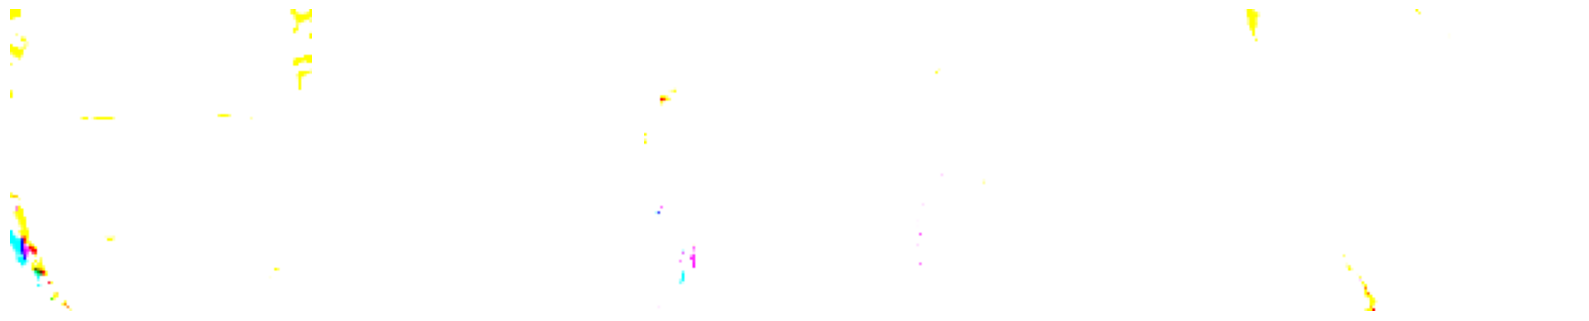

In [ ]:
ds_query, ds_distr = get_datasets_celeba_full_ir()
dl_query, dl_distr = get_dataloaders(None, ds_query, ds_distr, 5)

sample_images, _ = next(iter(dl_distr))
show_images(sample_images, inv_normalize=inv_normalize)

## Dataset: CelebA500 (IR split)

### Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT_SAVE_DIR = '/content/drive/MyDrive/practice/DSL1-project-face-recognition'
ROOT_WORK_DIR = '.'
ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'data')

IR_ZIP_PATH = os.path.join(ROOT_SAVE_DIR, 'celebA_ir.zip')
!unzip -qn {IR_ZIP_PATH} -d {ROOT_DATA_DIR}

CELEBA_IR_DIR = os.path.join(ROOT_DATA_DIR, 'celebA_ir')

Mounted at /content/drive


In [ ]:
!ls {CELEBA_IR_DIR}

celebA_anno_query.csv  celebA_distractors  celebA_query


### Read metadata & prepare dataset

In [ ]:
file_path = os.path.join(CELEBA_IR_DIR, 'celebA_anno_query.csv')
anno_df = pd.read_csv(file_path)
anno_df.head()

img  id
0  001265.jpg  35
1  001430.jpg  35
2  012834.jpg  35
3  041171.jpg  35
4  041823.jpg  35

In [ ]:
imgs_dir = os.path.join(CELEBA_IR_DIR, 'celebA_distractors')
image_filenames = os.listdir(imgs_dir)
id_to_img_names = {id: df['img'].to_list() for id, df in anno_df.groupby('id')}

In [ ]:
import pandas as pd
from PIL import Image

class CelebA500DatasetIR(Dataset):
    def __init__(self, root_dir, split='query', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        assert split in ['query', 'distractors']

        self.transform = transform

        if split == 'query':
            self.imgs_dir = os.path.join(root_dir, 'celebA_query')

            file_path = os.path.join(root_dir, 'celebA_anno_query.csv')
            anno_df = pd.read_csv(file_path)

            self.image_filenames = anno_df['img'].to_list()
            self.labels = torch.tensor(anno_df['id'].to_numpy())
            self.id_to_idx = {id: df['img'].index.to_list() for id, df in anno_df.groupby('id')}

        elif split == 'distractors':
            self.imgs_dir = os.path.join(root_dir, 'celebA_distractors')

            self.image_filenames = os.listdir(imgs_dir)
            self.labels = torch.full((len(image_filenames),), np.nan) # distractors' ids are unknown

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_filepath = os.path.join(self.imgs_dir, self.image_filenames[idx])
        image = Image.open(img_filepath)
        if self.transform is not None:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

In [ ]:
class SquarePad(object):
	def __call__(self, image):
		h, w = image.size(-2), image.size(-1)
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return transforms.functional.pad(image, padding, 0, 'constant')

In [ ]:
RESCALE_SIZE = 112

MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    SquarePad(),
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
    transforms.Normalize(MEAN, STD)
])

inv_normalize = transforms.Normalize(
    mean = -MEAN / STD,
    std = 1 / STD
)

In [ ]:
#@title CelebA 500 IR datasets getter
def get_datasets_celeba_500_ir():
    ds_query = CelebA500DatasetIR(CELEBA_IR_DIR, 'query', transform=transform)
    ds_distr = CelebA500DatasetIR(CELEBA_IR_DIR, 'distractors', transform=transform)
    return ds_query, ds_distr

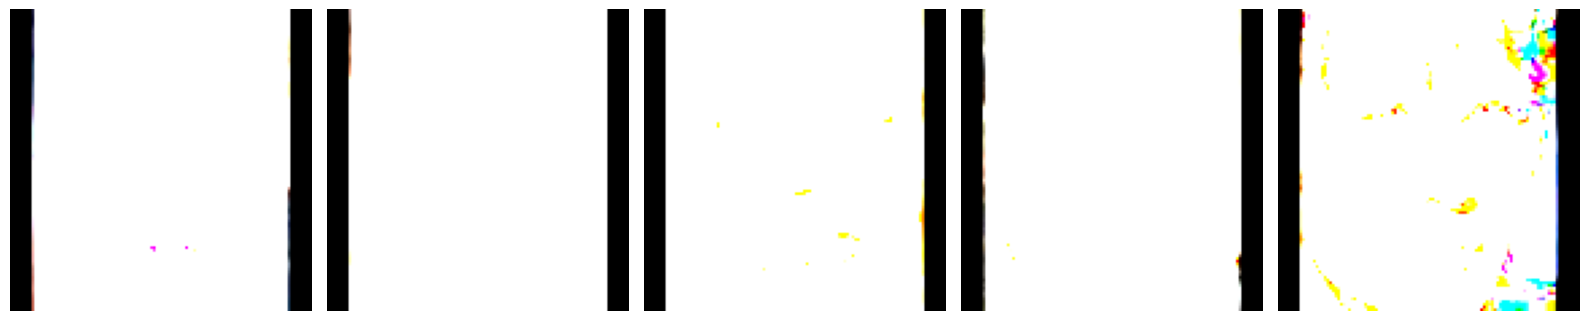

In [ ]:
ds_query, ds_distr = get_datasets_celeba_500_ir()
dl_query, dl_distr = get_dataloaders(None, ds_query, ds_distr, 5)

sample_images, _ = next(iter(dl_distr))
show_images(sample_images, inv_normalize=inv_normalize)

## Contrastive sampler & dataset

Создадим кастомный сэмплер, который обладает следующими свойствами:

1. В каждом батче размера $B$ присутствуют изображения ровно для $P$ персон, по $K$ изображений на каждого. При этом если в процессе формирования очередного батча для какой-либо персоны остается меньше $K$ изображений, они не используются.

2. Выбор изображений для каждого батча происходит без повторений - каждое изображение в датасете либо используется единожды, либо не используется (так как невозможного сформировать батч с заданными параметрами)


### Batching without replacement

In [ ]:
# create a mask for used images for each id

id_to_idx = {
    id: ma.array(idx, mask=np.zeros(len(idx), dtype=bool))
    for id, idx in dsi_train.id_to_idx.items()
}

id_to_idx[list(id_to_idx.keys())[0]]

masked_array(data=[22, 4505, 6438, 14041, 15215, 23003, 24090, 27826,
                   30453, 32403, 33489, 49380, 51161, 56278, 64537, 67806,
                   67854, 68168, 87502, 90780, 108997, 111432, 112543,
                   117149, 130349, 142585, 142873, 145589, 157601],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False],
       fill_value=999999)

In [ ]:
# discard ids with images count less than theshold

imgs_per_id = 20

id_to_idx = {
    id: idx
    for id, idx in id_to_idx.items() if len(idx) >= imgs_per_id
}

In [ ]:
# create a mask for ids all images of which have been used

all_ids_cnt = len(id_to_idx.keys())
all_ids = ma.array(
    list(id_to_idx.keys()), # assume label encoding: [0, N-1]
    mask=np.zeros(all_ids_cnt, dtype=bool)
    )
all_ids

masked_array(data=[0, 2, 3, ..., 10173, 10174, 10175],
             mask=[False, False, False, ..., False, False, False],
       fill_value=999999)

In [ ]:
# choose random ids for which not all of the images are used

ids_per_batch = 3

batch_ids = np.random.choice(all_ids[~all_ids.mask], ids_per_batch, replace=False)
batch_ids

array([5085, 7798, 1784])

In [ ]:
# choose random images indices for each chosen id

all_indices = []
for id in batch_ids:
    idx = id_to_idx[id]
    idx_indices = np.arange(len(idx))
    pos_idx_indices = np.random.choice(
        idx_indices[~idx.mask], # ignore all used images
        imgs_per_id, replace=False
    )

    all_indices.append(idx[pos_idx_indices].data)
    id_to_idx[id].mask[pos_idx_indices] = True # mask used images

all_indices = np.concatenate(all_indices)
all_indices

array([129058,  52736,   1097,  30261,  92214, 131684, 115445, 116041,
        49773,  33600,  72361, 120481, 111064, 150367,  89115,  80628,
       137070,  77298,  75642, 116441, 153738,  70809,  96042,  11900,
       136225, 111642, 112107, 151030,  61737,  62182,  90943, 149106,
       115911,  26602,  53790, 122154,  77952,  48076, 150824,  91968,
        98523,  33294,  31632, 100022, 111282,  40338,  64115,  33743,
       153351,   5363, 142702,  28216,   2028, 129064, 102432, 110996,
        38810,  95387,  48059,  65395])

In [ ]:
# masks of used images are updated for each id in current batch

for id in batch_ids:
    print(id_to_idx[id].mask)

[ True False  True  True  True  True False  True  True  True  True  True
  True False False  True False  True  True  True False  True  True False
  True  True False False  True False]
[ True  True False  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True False]
[ True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True False]


In [ ]:
# mask ids all images of which were used (and thus the list of available images got exhausted)

for id in batch_ids:
    idx = id_to_idx[id]
    unused_imgs_cnt = len(idx) - idx.mask.sum() # unused images count

    # mask id if too small image count
    all_ids.mask[all_ids == id] = unused_imgs_cnt < imgs_per_id

all_ids[np.isin(all_ids, batch_ids)]

masked_array(data=[--, --, --],
             mask=[ True,  True,  True],
       fill_value=999999,
            dtype=int64)

In [ ]:
#@title UniformContrastiveSamplerWithReplacement

# TODO: fix batch count (?)

from torch.utils.data import BatchSampler
import random

class UniformContrastiveSamplerWithReplacement(BatchSampler):
    def __init__(self, dataset, imgs_per_id, batch_size, shuffle=True, seed=None):
        """
        Creates uniform batches such that each batch contains:
            - same number of ids
            - same number of images per each id
        Ids and images are sampled at random WITH replacement,
        meaning that the sampler is NOT guaranteed to:
            - use all possible images and all possible ids
            - create fully unique batches (might contain same images)

        In a batch number of positives per anchor equals imgs_per_id - 1.
        params:
            imgs_per_id: number of images sampled per id
            batch_size: ...
            shuffle: set to True to have the data reshuffled at every epoch (default: False)
            seed: seed used for shuffling if shuffling is enabled
        """
        assert batch_size % imgs_per_id == 0, "batch_size should be divisible by img_per_id"

        self.imgs_per_id = imgs_per_id
        self.batch_size = batch_size
        self.ids_per_batch = int(batch_size / imgs_per_id)

        self.id_to_idx = {id: idx for id, idx in dataset.id_to_idx.items() if len(idx) >= imgs_per_id}

        self.shuffle = shuffle

        if shuffle == False:
            self.seed = seed if seed is not None else 42
        else:
            self.seed = None

    def __iter__(self):
        rng = np.random.default_rng(self.seed)

        all_ids = list(self.id_to_idx.keys())
        dataset_length = len(self)
        batch_size = self.batch_size

        all_indices = []
        for _ in range(dataset_length):
            batch_ids = rng.choice(all_ids, self.ids_per_batch, replace=False)
            for id in batch_ids:
                positives_idx = rng.choice(self.id_to_idx[id], self.imgs_per_id, replace=False)
                all_indices.append(positives_idx)
        all_indices = np.concatenate(all_indices)

        for i in range(0, dataset_length, batch_size):
            yield all_indices[i:i + batch_size]

    def __len__(self):
        batch_cnt = int(len(self.id_to_idx.keys()) / self.ids_per_batch)
        return (batch_cnt)

In [ ]:
from copy import deepcopy
from time import perf_counter
from datetime import timedelta

# TODO: use remaining images to generate batches, not just discard them
# TODO: precalculate precise number of batches

#@title UniformContrastiveSampler
class UniformContrastiveSampler(BatchSampler):
    def __init__(self, dataset, imgs_per_id, batch_size, shuffle=True, seed=None):
        """
        Creates uniform batches such that each batch contains:
            - same number of ids
            - same number of images per each id
        Ids and images are sampled at random WITHOUT replacement,
        meaning that the sampler is guaranteed to:
            - use all possible images and all possible ids
            - create fully unique batches (which do NOT contain same images)

        In a batch number of positives per anchor equals imgs_per_id - 1.
        params:
            imgs_per_id: number of images sampled per id
            batch_size: ...
            shuffle: whether to reshuffle data every epoch (default: False)
            seed: seed used for shuffling if shuffling is enabled
        """
        assert batch_size % imgs_per_id == 0, "batch_size should be divisible by img_per_id"

        self.imgs_per_id = imgs_per_id
        self.batch_size = batch_size
        self.ids_per_batch = int(batch_size / imgs_per_id)

        # discard ids with images count less than theshold
        self.id_to_idx = {
            id: idx
            for id, idx in dataset.id_to_idx.items() if len(idx) >= self.imgs_per_id
        }

        self.shuffle = shuffle

        if shuffle == False:
            self.seed = seed if seed is not None else 42
        else:
            self.seed = None

        tic = perf_counter()
        self.all_indices = self._compute_all_indices()
        toc = perf_counter()

        print(
            f"Time spent generating {self.total_batches} batches" \
            f" of size {self.batch_size}" \
            f" for {self.imgs_per_id} images per id" \
            f" for {self.ids_per_batch} ids per batch"
            f" : {timedelta(seconds=toc-tic)}")

    def _compute_all_indices(self):
        rng = np.random.default_rng(self.seed)

        # create a mask for used images for each id
        id_to_idx = {
            id: ma.array(idx, mask=np.zeros(len(idx), dtype=bool))
            for id, idx in self.id_to_idx.items()
        }

        # create a mask for ids all images of which have been used
        all_ids_cnt = len(id_to_idx.keys())
        all_ids = ma.array(
            list(id_to_idx.keys()),
            mask=np.zeros(all_ids_cnt, dtype=bool)
            )

        total_batches = 0
        all_indices = []
        while len(all_ids[~all_ids.mask]) >= self.ids_per_batch:
            # choose random ids for which not all of the images are used
            batch_ids = rng.choice(
                all_ids[~all_ids.mask],
                self.ids_per_batch, replace=False
            )

            # choose images indices for each id
            for id in batch_ids:
                idx = id_to_idx[id]
                idx_indices = np.arange(len(idx))
                pos_idx_indices = rng.choice(
                    idx_indices[~idx.mask], # ignore all used images
                    self.imgs_per_id, replace=False
                )

                all_indices.append(idx[pos_idx_indices].data)
                id_to_idx[id].mask[pos_idx_indices] = True # mask used images

                unused_imgs_cnt = len(idx) - idx.mask.sum()
                all_ids.mask[all_ids.data == id] = unused_imgs_cnt < self.imgs_per_id

            total_batches += 1

        all_indices = np.concatenate(all_indices)
        self.total_batches = total_batches

        # TODO: precalculate precise number of batches
        # total_batches = sum([len(idx) // self.imgs_per_id for id, idx in self.id_to_idx.items()]) \
        #     / self.ids_per_batch
        # print(self.total_batches, total_batches)

        return all_indices

    def __iter__(self):
        # compute indices if not precomputed
        if self.all_indices is None:
            self.all_indices = self._compute_all_indices()

        all_indices = deepcopy(self.all_indices)
        self.all_indices = None # remove precomputed for next epoch

        for i in range(0, len(all_indices), self.batch_size):
            yield all_indices[i:i + self.batch_size]

    def __len__(self):
        return self.total_batches

In [ ]:
#@title Contrasive dataloaders getter
def get_dataloaders_contrastive(
        ds_train, ds_valid, ds_test,
        imgs_per_id, batch_size
        ):
    common_sampler_opts = dict(
        imgs_per_id=imgs_per_id,
        batch_size=batch_size,
    )

    contrastive_sampler_train = UniformContrastiveSampler(
        **common_sampler_opts,
        dataset=ds_train,
        shuffle=True
    )

    contrastive_sampler_valid = UniformContrastiveSampler(
        **common_sampler_opts,
        dataset=ds_valid,
        shuffle=False
    )

    contrastive_sampler_test = UniformContrastiveSampler(
        **common_sampler_opts,
        dataset=ds_test,
        shuffle=False
    )

    dl_contrastive_train = DataLoader(ds_train, batch_sampler=contrastive_sampler_train)
    dl_contrastive_valid = DataLoader(ds_valid, batch_sampler=contrastive_sampler_valid)
    dl_contrastive_test = DataLoader(ds_test, batch_sampler=contrastive_sampler_test)

    return dl_contrastive_train, dl_contrastive_valid, dl_contrastive_test

In [ ]:
dl_contrastive_train, dl_contrastive_valid, dl_contrastive_test =  \
get_dataloaders_contrastive(
    dsi_train, dsi_valid, dsi_test,
    imgs_per_id=4,
    batch_size=16
)

batch = next(iter(dl_contrastive_valid))
imgs, labels = batch
imgs.shape, labels

Time spent generating 9418 batches of size 16 for 4 images per id for 4 ids per batch : 0:00:07.618765
Time spent generating 1149 batches of size 16 for 4 images per id for 4 ids per batch : 0:00:00.340045
Time spent generating 1152 batches of size 16 for 4 images per id for 4 ids per batch : 0:00:00.369243


(torch.Size([16, 3, 112, 112]),
 tensor([2107, 2107, 2107, 2107,  513,  513,  513,  513, 3110, 3110, 3110, 3110,
         3702, 3702, 3702, 3702]))

In [ ]:
# valid/test loaders are reproducible across epochs

_, labels1 = next(iter(dl_contrastive_valid))
_, labels2 = next(iter(dl_contrastive_valid))
torch.allclose(labels1, labels2)

True

In [ ]:
# train loader is NOT reproducible across epochs

_, labels1 = next(iter(dl_contrastive_train))
_, labels2 = next(iter(dl_contrastive_train))
torch.allclose(labels1, labels2)

False

# Face detection

## Loss functions

### Combined margin loss

Самый простой лосс, который применяется в задаче распознавания лиц - softmax loss (a.k.a. Cross Entropy loss)

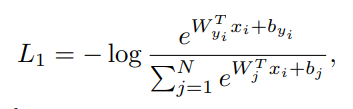

Если нормализовать веса линейного слоя и эмбеддингов, а также положить bias=0, то возможно будет составить лосс функцию, значение которой зависит только от угла $\Theta$ между эмбеддиингами и весами. Получим нормализованный угловой softmax loss:

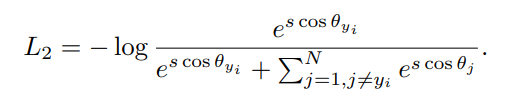

Добавим к нормализованному угловому softmax loss штрафы зазора (margin penalties):
* $m_1$ - мультипликативный угловой зазор
* $m_2$ - аддитивный угловой зазор
* $m_3$ - аддитвный косинусный зазор

Так мы получим лосс, совмещающий в себе лоссы SphereFace, ArcFace, CosFace:

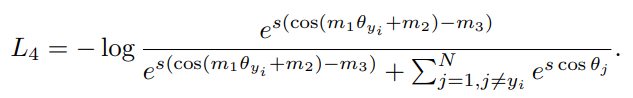

Приведем пошаговый пример расчета Combined Margin Loss по полученной формуле

In [ ]:
BATCH_SIZE = 8
EMB_DIM = 32
NUM_CLASSES = 10

SCALE = torch.rand(1)
M1 = torch.rand(1)
M2 = torch.rand(1)
M3 = torch.rand(1)

In [ ]:
# generate random embeddings and target labels

embs = torch.rand(BATCH_SIZE, EMB_DIM)
labels = torch.randint(1, NUM_CLASSES, (BATCH_SIZE,))
embs.shape, labels.shape

(torch.Size([8, 32]), torch.Size([8]))

In [ ]:
# generate random weight for linear layer

weight = torch.rand(NUM_CLASSES, EMB_DIM)
weight.shape

torch.Size([10, 32])

In [ ]:
# embeddings (logits) -> cosine distances between embeddings and centers

x_normed = F.normalize(embs)
W_normed = F.normalize(weight)

cos_theta = F.linear(embs, weight)
cos_theta = cos_theta.clamp(-1, 1) # for arccos
cos_theta.shape

torch.Size([8, 10])

In [ ]:
# cosine distances -> theta angles between embeddins and centers

theta = torch.acos(cos_theta)
theta.shape

torch.Size([8, 10])

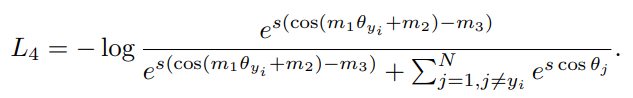

In [ ]:
# apply penalties

theta_m1 = theta * M1 # apply SphereFace penalty

theta_m1_m2 = theta_m1 + M2 # apply ArcFace penalty
cos_theta_m1_m2 = torch.cos(theta_m1_m2)

cos_theta_m1_m2_m3 = cos_theta_m1_m2 - M3 # apply CosFace penalty

Альтернативная формула для вычисления второго штрафа
$ cos(m_1\Theta + m_2) = cos(m_1\Theta)cos(m2) - sin(m_1\Theta)sin(m2)$

In [ ]:
cos_m2 = math.cos(M2)
sin_m2 = math.cos(M2)

cos_theta_m1 = torch.cos(theta_m1)
sin_theta_m1 = torch.sqrt(1 - torch.pow(cos_theta_m1, 2)) # by trig identity

cos_theta_m1_m2 = cos_theta_m1 * cos_m2 - sin_theta_m1 * sin_m2

In [ ]:
# one hot encode target labels

one_hot = torch.zeros_like(cos_theta, dtype=torch.bool)
one_hot.scatter_(1, labels.view(-1, 1), True)
one_hot

tensor([[False, False,  True, False, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, False, False,  True, False, False]])

In [ ]:
# replace cosine distances for target classes with penalized ones

cos_theta[one_hot] = cos_theta_m1_m2_m3[one_hot]

In [ ]:
# scale logits

cos_theta *= SCALE

In [ ]:
# compute loss

logits = cos_theta
loss = F.cross_entropy(logits, labels)
loss.item()

2.39969801902771

In [ ]:
#@title SoftmaxLoss
class SoftmaxLoss(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxLoss, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, inputs, targets):
        # Apply linear layer
        logits = self.linear(inputs)

        # Calculate cross-entropy loss
        loss = F.cross_entropy(logits, targets)

        return loss, logits

In [ ]:
#@title AngularSoftmaxLoss
import torch
import torch.nn as nn
import torch.nn.functional as F

class AngularSoftmaxLoss(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        # Initialize weight matrix
        self.weight = nn.Parameter(torch.Tensor(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, target):
        # Normalize the weight matrix
        weight = F.normalize(self.weight, dim=1)

        # Normalize the input features
        x = F.normalize(x, dim=1)

        # Compute the cosine similarity (dot product of normalized vectors)
        logits = torch.mm(x, weight.t())

        # Scale the logits (optional, usually a hyperparameter)
        scale = 30.0
        logits = logits * scale

        # Compute the angular softmax loss
        loss = F.cross_entropy(logits, target)
        return loss

In [ ]:
# sanity check
asoftmax_loss = AngularSoftmaxLoss(EMB_DIM, NUM_CLASSES)
loss = asoftmax_loss(embs, labels)
loss.item()

4.719577789306641

In [ ]:
#@title CombinedMarginLoss module
import math

class CombinedMarginLoss(nn.Module):
    def __init__(self, s, m1, m2, m3, num_classes, emb_dim):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.weight = nn.Parameter(torch.Tensor(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m2 = math.cos(self.m2)
        self.sin_m2 = math.cos(self.m2)

    def forward(self, embs, labels):
        cos_theta = F.linear(F.normalize(embs), F.normalize(self.weight))
        cos_theta = cos_theta.float()

        cos_theta = cos_theta.clamp(-1, 1) # for arccos
        theta = torch.acos(cos_theta)

        # apply SphereFace penalty
        theta_m1 = theta * self.m1
        cos_theta_m1 = torch.cos(theta_m1)
        sin_theta_m1 = torch.sqrt(1 - torch.pow(cos_theta_m1, 2)) # by trig identity

        # apply ArcFace penalty
        cos_theta_m1_m2 = cos_theta_m1 * self.cos_m2 - sin_theta_m1 * self.sin_m2

        # apply CosFace penalty
        cos_theta_m1_m2_m3 = cos_theta_m1_m2 - self.m3

        one_hot = torch.zeros_like(cos_theta, dtype=torch.bool)
        one_hot.scatter_(1, labels.view(-1, 1), True)

        cos_theta_adjusted = cos_theta.clone()
        cos_theta_adjusted[one_hot] = cos_theta_m1_m2_m3[one_hot]
        cos_theta_adjusted = cos_theta_adjusted * self.s
        loss = F.cross_entropy(cos_theta_adjusted, labels)

        # TODO: more efficient memory usage with scatter_
        # cos_theta.scatter_(0, labels.view(-1, 1), cos_theta_m1_m2_m3[one_hot])
        # cos_theta = cos_theta * self.s
        # loss = F.cross_entropy(cos_theta, labels)
        return loss

In [ ]:
# sanity check
torch.manual_seed(GLOBAL_SEED)
margin_loss = CombinedMarginLoss(SCALE, M1, M2, M3, NUM_CLASSES, EMB_DIM)
loss = margin_loss(embs, labels)
loss.item()

2.3550922870635986

In [ ]:
#@title Reference Combined Margin loss module
class ReferenceCombinedMarginLoss(torch.nn.Module):
    def __init__(self,
                 s,
                 m1,
                 m2,
                 m3,
                 num_classes,
                 emb_dim,
                 interclass_filtering_threshold=0):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.interclass_filtering_threshold = interclass_filtering_threshold
        self.weight = nn.Parameter(torch.Tensor(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)

        # For ArcFace
        self.cos_m = math.cos(self.m2)
        self.sin_m = math.sin(self.m2)
        self.theta = math.cos(math.pi - self.m2)
        self.sinmm = math.sin(math.pi - self.m2) * self.m2
        self.easy_margin = False


    def forward(self, embs, labels):
        logits = F.linear(F.normalize(embs), F.normalize(self.weight))
        logits = logits.float().clamp(-1, 1)
        index_positive = torch.where(labels != -1)[0]

        if self.interclass_filtering_threshold > 0:
            with torch.no_grad():
                dirty = logits > self.interclass_filtering_threshold
                dirty = dirty.float()
                mask = torch.ones([index_positive.size(0), logits.size(1)], device=logits.device)
                mask.scatter_(1, labels[index_positive], 0)
                dirty[index_positive] *= mask
                tensor_mul = 1 - dirty
            logits = tensor_mul * logits

        target_logit = logits[index_positive, labels[index_positive].view(-1)]

        if self.m1 == 1.0 and self.m3 == 0.0:
            with torch.no_grad():
                target_logit.arccos_()
                logits.arccos_()
                final_target_logit = target_logit + self.m2
                logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
                logits.cos_()
            logits = logits * self.s

        elif self.m3 > 0:
            final_target_logit = target_logit - self.m3
            logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
            logits = logits * self.s
        else:
            raise

        loss = F.cross_entropy(logits, labels)

        return loss

In [ ]:
# sanity check
torch.manual_seed(GLOBAL_SEED)
ref_margin_loss = ReferenceCombinedMarginLoss(SCALE, M1, M2, M3, NUM_CLASSES, EMB_DIM)
loss = ref_margin_loss(embs, labels)
loss.item()

2.4102513790130615

### Triplet loss

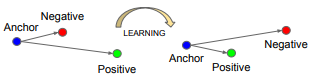

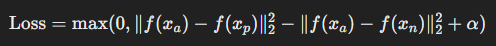

#### Batch all

In [ ]:
BATCH_SIZE = 4
PERSONS = 2
EMB_DIM = 10

# for triplet loss there wll be exactly 2 images per each person in a batch
assert BATCH_SIZE % 2 == 0 and BATCH_SIZE // PERSONS == 2

In [ ]:
# generate random batch
embeddings_raw = torch.rand(BATCH_SIZE, EMB_DIM)
labels = torch.empty(BATCH_SIZE, dtype=int)
imgs_per_person = BATCH_SIZE // PERSONS
for person_idx in range(PERSONS):
    labels[person_idx * imgs_per_person : (person_idx + 1) * imgs_per_person] = person_idx
labels

tensor([0, 0, 1, 1])

In [ ]:
embeddings = F.normalize(embeddings_raw)
dot_product = torch.mm(embeddings, embeddings.T)
square_norm = torch.diag(dot_product)
square_norm.shape, dot_product.shape

(torch.Size([4]), torch.Size([4, 4]))

In [ ]:
dist = square_norm.reshape(1, -1) - 2.0 * dot_product + square_norm.reshape(1, -1).T
dist = F.relu(dist) # fix negative distances from computation errors
dist

tensor([[0.0000, 0.7568, 0.3621, 0.6686],
        [0.7568, 0.0000, 0.2446, 0.5961],
        [0.3621, 0.2446, 0.0000, 0.5039],
        [0.6686, 0.5961, 0.5039, 0.0000]])

In [ ]:
# root square version
mask = torch.eq(dist, 0)
dist = dist + mask * 1e-16 # make sure not to divide by 0 in grad of sqrt(x)
dist = torch.sqrt(dist)
dist = dist * (~mask) # remove epsilon
dist

tensor([[0.0000, 0.8700, 0.6018, 0.8177],
        [0.8700, 0.0000, 0.4945, 0.7721],
        [0.6018, 0.4945, 0.0000, 0.7098],
        [0.8177, 0.7721, 0.7098, 0.0000]])

In [ ]:
# dist(a, p) for all possible negatives
batch_size = dist.shape[0]
anchor_pos_dist = dist.reshape(batch_size, batch_size, 1).expand(-1, -1, batch_size)
anchor_pos_dist

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.8700, 0.8700, 0.8700, 0.8700],
         [0.6018, 0.6018, 0.6018, 0.6018],
         [0.8177, 0.8177, 0.8177, 0.8177]],

        [[0.8700, 0.8700, 0.8700, 0.8700],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.4945, 0.4945, 0.4945, 0.4945],
         [0.7721, 0.7721, 0.7721, 0.7721]],

        [[0.6018, 0.6018, 0.6018, 0.6018],
         [0.4945, 0.4945, 0.4945, 0.4945],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.7098, 0.7098, 0.7098, 0.7098]],

        [[0.8177, 0.8177, 0.8177, 0.8177],
         [0.7721, 0.7721, 0.7721, 0.7721],
         [0.7098, 0.7098, 0.7098, 0.7098],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [ ]:
# dist(a, n) for all possible positives
anchor_neg_dist = dist.reshape(batch_size, 1, batch_size).expand(-1, batch_size, -1)
anchor_neg_dist

tensor([[[0.0000, 0.8700, 0.6018, 0.8177],
         [0.0000, 0.8700, 0.6018, 0.8177],
         [0.0000, 0.8700, 0.6018, 0.8177],
         [0.0000, 0.8700, 0.6018, 0.8177]],

        [[0.8700, 0.0000, 0.4945, 0.7721],
         [0.8700, 0.0000, 0.4945, 0.7721],
         [0.8700, 0.0000, 0.4945, 0.7721],
         [0.8700, 0.0000, 0.4945, 0.7721]],

        [[0.6018, 0.4945, 0.0000, 0.7098],
         [0.6018, 0.4945, 0.0000, 0.7098],
         [0.6018, 0.4945, 0.0000, 0.7098],
         [0.6018, 0.4945, 0.0000, 0.7098]],

        [[0.8177, 0.7721, 0.7098, 0.0000],
         [0.8177, 0.7721, 0.7098, 0.0000],
         [0.8177, 0.7721, 0.7098, 0.0000],
         [0.8177, 0.7721, 0.7098, 0.0000]]])

In [ ]:
# batch all loss
margin = 0.2

anchor_pos_dist = dist.reshape(batch_size, batch_size, 1) # use broadasting trick
anchor_neg_dist = dist.reshape(batch_size, 1, batch_size)# use broadasting trick
loss = anchor_pos_dist - anchor_neg_dist + margin
loss.shape

torch.Size([4, 4, 4])

In [ ]:
mask = torch.empty(batch_size, batch_size, batch_size)
for i in torch.arange(batch_size):
    for j in torch.arange(batch_size):
        for k in torch.arange(batch_size):
            mask[i, j, k] = not (labels[i] != labels[j] or i == j or labels[i] == labels[k])

# mask

In [ ]:
loss = loss * mask
loss = F.relu(loss) # remove negative losses (easy triplets)
loss

tensor([[[0.0000, -0.0000, -0.0000, -0.0000],
         [0.0000, 0.0000, 0.4682, 0.2523],
         [0.0000, -0.0000, 0.0000, -0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.5754, 0.2979],
         [-0.0000, 0.0000, -0.0000, -0.0000],
         [-0.0000, 0.0000, 0.0000, -0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, -0.0000],
         [-0.0000, -0.0000, 0.0000, -0.0000],
         [0.3080, 0.4153, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0921, 0.1377, 0.0000, 0.0000],
         [-0.0000, -0.0000, -0.0000, 0.0000]]])

In [ ]:
num_pos = (loss > 1e-16).sum()
loss = loss.sum() / (num_pos + 1e-16)
loss

tensor(0.3184)

In [ ]:
#@title BatchAllTripletLoss module

class PairwiseDistances(nn.Module):
    def __init__(self, squared):
        super().__init__()
        self.squared = squared

    def forward(self, embeddings):
        dot_product = torch.mm(embeddings, embeddings.T)
        square_norm = torch.diag(dot_product)

        dist = square_norm.reshape(1, -1) - 2.0 * dot_product + square_norm.reshape(1, -1).T
        dist = F.relu(dist) # fix negative distances from computation errors

        if not self.squared:
            mask = torch.eq(dist, 0)
            dist = dist + mask * 1e-16 # make sure not to divide by 0 in grad of sqrt(x)
            dist = torch.sqrt(dist)
            dist = dist * (~mask) # remove epsilon

        return dist

class BatchAllTripletLoss(nn.Module):
    def __init__(self, margin, squared=False):
        super().__init__()
        self.margin = margin
        self.pairwise_distances = PairwiseDistances(squared)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        dist = self.pairwise_distances(embeddings)

        # compute loss for all triplets
        anchor_pos_dist = dist.reshape(batch_size, batch_size, 1) # use broadasting trick
        anchor_neg_dist = dist.reshape(batch_size, 1, batch_size) # use broadasting trick
        loss = anchor_pos_dist - anchor_neg_dist + self.margin
        for i in torch.arange(batch_size):
            for j in torch.arange(batch_size):
                for k in torch.arange(batch_size):
                    mask[i, j, k] = not (labels[i] != labels[j] or i == j or labels[i] == labels[k])

        loss = loss * mask
        loss = F.relu(loss) # remove negative losses (easy triplets)
        num_pos = (loss > 1e-16).sum()
        loss = loss.sum() / (num_pos + 1e-16)
        return loss

In [ ]:
batch_all_loss = BatchAllTripletLoss(0.2)
my_loss_all = batch_all_loss(embeddings_raw, labels)
my_loss_all

tensor(0.3184)

#### Batch hardest

In [ ]:
# get anchor posititve triplet mask
indices_not_equal = ~torch.eye(labels.shape[0], dtype=bool)
labels_equal = torch.eq(labels.reshape(1, -1), labels.reshape(-1, 1))
mask_anchor_pos = torch.logical_and(indices_not_equal, labels_equal).float()
mask_anchor_pos

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])

In [ ]:
# get anchor negative triplet mask
mask_anchor_neg = ( ~torch.eq(labels.reshape(1, -1), labels.reshape(-1, 1)) ).float()
mask_anchor_neg

tensor([[0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.]])

In [ ]:
# get distance only for positives
anchor_pos_dist = dist * mask_anchor_pos
anchor_pos_dist

tensor([[0.0000, 0.8700, 0.0000, 0.0000],
        [0.8700, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7098],
        [0.0000, 0.0000, 0.7098, 0.0000]])

In [ ]:
# get distance only for negatives
anchor_neg_dist = dist * mask_anchor_neg
anchor_neg_dist

tensor([[0.0000, 0.0000, 0.6018, 0.8177],
        [0.0000, 0.0000, 0.4945, 0.7721],
        [0.6018, 0.4945, 0.0000, 0.0000],
        [0.8177, 0.7721, 0.0000, 0.0000]])

In [ ]:
# select hardest pos/neg

hardest_pos_dist, _ = anchor_pos_dist.max(1, keepdim=True)

# TODO: explain why not just take min for negatives
max_anchor_neg_dist, _= anchor_neg_dist.max(1, keepdim=True)
anchor_neg_dist = dist + max_anchor_neg_dist * (1.0 - mask_anchor_neg)
hardest_neg_dist, _ = anchor_neg_dist.min(1, keepdim=True)
hardest_pos_dist, hardest_neg_dist

(tensor([[0.8700],
         [0.8700],
         [0.7098],
         [0.7098]]),
 tensor([[0.6018],
         [0.4945],
         [0.4945],
         [0.7721]]))

In [ ]:
loss = F.relu(hardest_pos_dist - hardest_neg_dist + margin)
loss = loss.mean()
loss

tensor(0.3992)

In [ ]:
#@title TripletBatchHardLoss module

class PairwiseDistances(nn.Module):
    def __init__(self, squared):
        super().__init__()
        self.squared = squared

    def forward(self, embeddings):
        dot_product = torch.mm(embeddings, embeddings.T)
        square_norm = torch.diag(dot_product)

        dist = square_norm.reshape(1, -1) - 2.0 * dot_product + square_norm.reshape(1, -1).T
        dist = F.relu(dist) # fix negative distances from computation errors

        if not self.squared:
            mask = torch.eq(dist, 0)
            dist = dist + mask * 1e-16 # make sure not to divide by 0 in grad of sqrt(x)
            dist = torch.sqrt(dist)
            dist = dist * (~mask) # remove epsilon

        return dist

class TripletBatchHardLoss(nn.Module):
    def __init__(self,
                 margin,
                 squared=False,
                 num_classes=None # for Loss module interface consistency
                 ):
        super().__init__()
        self.margin = margin
        self.pairwise_distances = PairwiseDistances(squared)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        dist = self.pairwise_distances(embeddings)

        # get anchor posititve triplet mask
        indices_not_equal = ~torch.eye(labels.shape[0], dtype=bool, device=labels.device)
        labels_equal = torch.eq(labels.reshape(1, -1), labels.reshape(-1, 1))
        mask_anchor_pos = torch.logical_and(indices_not_equal, labels_equal).float()

        # get anchor negative triplet mask
        mask_anchor_neg = ( ~torch.eq(labels.reshape(1, -1), labels.reshape(-1, 1)) ).float()

        # get distance only for positives/neg
        anchor_pos_dist = dist * mask_anchor_pos
        anchor_neg_dist = dist * mask_anchor_neg

        # select hardest pos
        hardest_pos_dist, _ = anchor_pos_dist.max(1, keepdim=True)

        # select hardest neg
        # TODO: explain why not just take min for negatives
        max_anchor_neg_dist, _= anchor_neg_dist.max(1, keepdim=True)
        anchor_neg_dist = dist + max_anchor_neg_dist * (1.0 - mask_anchor_neg)
        hardest_neg_dist, _ = anchor_neg_dist.min(1, keepdim=True)
        loss = F.relu(hardest_pos_dist - hardest_neg_dist + self.margin)
        loss = loss.mean()
        return loss

BatchHardTripletLoss = TripletBatchHardLoss

In [ ]:
batch_hardest_loss = TripletBatchHardLoss(0.2)
my_loss_hard = batch_hardest_loss(embeddings_raw, labels)
my_loss_hard

tensor(0.3992)

#### Testing

Сравним выходы реализаций лоссов с авторскими, чтобы убедиться, что нет ошибок

In [ ]:
#@title TripletLoss (reference implementation)
# https://github.com/omoindrot/tensorflow-triplet-loss/blob/master/model/triplet_loss.py

"""Define functions to create the triplet loss with online triplet mining."""
import tensorflow as tf

tf.to_float = lambda x: tf.cast(x, tf.float32)

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask



def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.

    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
 Args: labels: tf.int32 `Tensor` with shape [batch_size] """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    # print(tf.shape(i_equal_j), tf.shape(tf.logical_not(i_equal_k)))
    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

In [ ]:
# TODO: fix CudaOutOfMemory on Kaggle

# embs_np = embeddings.numpy()
# embs_tf = tf.convert_to_tensor(embs_np)

# labels_np = labels.numpy()
# labels_tf = tf.convert_to_tensor(labels_np)

# loss_all, _ = batch_all_triplet_loss(labels_tf, embs_tf, margin=0.2)
# loss_hard = batch_hard_triplet_loss(labels_tf, embs_tf, margin=0.2)

# assert np.allclose(my_loss_all, loss_all)
# assert np.allclose(my_loss_hard, loss_hard)

### Contrastive loss

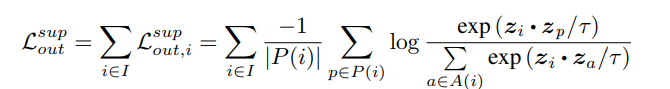

Пошаговое вычисление

In [ ]:
TEMPERATURE = 0.1

BATCH_SIZE = 4
EMB_DIM = 10
PERSONS = 2

assert BATCH_SIZE % PERSONS == 0

In [ ]:
# generate random batch
embeddings = torch.rand(BATCH_SIZE, EMB_DIM)
labels = torch.empty(BATCH_SIZE, dtype=int)
imgs_per_person = BATCH_SIZE // PERSONS
for person_idx in range(PERSONS):
    labels[person_idx * imgs_per_person : (person_idx + 1) * imgs_per_person] = person_idx
labels

tensor([0, 0, 1, 1])

In [ ]:
# calculate dot products and mask out dot product with self
embeddings = F.normalize(embeddings, dim=1)
sim_matrix = torch.matmul(embeddings, embeddings.T) / TEMPERATURE
self_mask = torch.eye(BATCH_SIZE, dtype=torch.bool)

# exclude distance with self from softmax calculation
sim_matrix = sim_matrix.masked_fill(self_mask, -1e9)
sim_matrix

tensor([[-1.0000e+09,  8.4036e+00,  7.4864e+00,  7.9503e+00],
        [ 8.4036e+00, -1.0000e+09,  7.3730e+00,  8.7968e+00],
        [ 7.4864e+00,  7.3730e+00, -1.0000e+09,  6.6808e+00],
        [ 7.9503e+00,  8.7968e+00,  6.6808e+00, -1.0000e+09]])

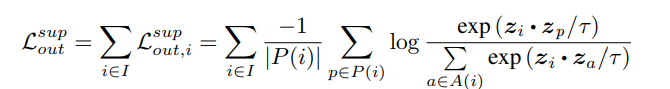

In [ ]:
# probability of similarity with self will be zero
exp_sim_matrix = torch.exp(sim_matrix)
exp_sim_matrix

tensor([[   0.0000, 4463.2827, 1783.5968, 2836.5603],
        [4463.2827,    0.0000, 1592.3835, 6612.7559],
        [1783.5968, 1592.3835,    0.0000,  796.9294],
        [2836.5603, 6612.7559,  796.9294,    0.0000]])

In [ ]:
log_prob = sim_matrix - torch.log(exp_sim_matrix.sum(0, keepdim=True))
log_prob

tensor([[-1.0000e+09, -1.0432e+00, -8.4998e-01, -1.2843e+00],
        [-7.1057e-01, -1.0000e+09, -9.6338e-01, -4.3791e-01],
        [-1.6278e+00, -2.0739e+00, -1.0000e+09, -2.5539e+00],
        [-1.1639e+00, -6.5011e-01, -1.6556e+00, -1.0000e+09]])

In [ ]:
F.log_softmax(sim_matrix, dim=1)

tensor([[-1.0000e+09, -7.1057e-01, -1.6278e+00, -1.1639e+00],
        [-1.0432e+00, -1.0000e+09, -2.0739e+00, -6.5011e-01],
        [-8.4998e-01, -9.6338e-01, -1.0000e+09, -1.6556e+00],
        [-1.2843e+00, -4.3791e-01, -2.5539e+00, -1.0000e+09]])

In [ ]:
# Create mask to identify positive samples
labels = labels.contiguous().view(-1, 1)
mask = torch.eq(labels, labels.T).float()
mask = mask * (~self_mask).float() # exclude diagonal
mask

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])

In [ ]:
# Take average loss over positives for each id and average the averages

mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1.0)
loss = -mean_log_prob_pos.mean()
loss

tensor(1.4908)

In [ ]:
#@title SupervisedContrastiveLoss module (my implementation)

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings, dim=-1)

        sim_matrix = torch.mm(embeddings, embeddings.T) / self.temperature
        self_mask = torch.eye(embeddings.shape[0], dtype=torch.bool, device=embeddings.device)

        large_neg_const = torch.tensor(-1e9, dtype=torch.float32)
        if torch.is_autocast_enabled():
            large_neg_const = large_neg_const.to(dtype=torch.float16)

        sim_matrix = sim_matrix.masked_fill(self_mask, large_neg_const)

        # TODO: exclude all positives from denominator ?
        # according to https://arxiv.org/pdf/2004.11362, Supplementary, pt. 11
        log_prob = F.log_softmax(sim_matrix, dim=1)

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float()
        mask = mask * (~self_mask).float()

        p = mask / mask.sum(dim=1).clamp(min=1.0)
        mean_log_prob_pos = (p * log_prob).sum(dim=1)
        loss = -mean_log_prob_pos.mean()

        return(loss)

In [ ]:
my_sup_con_loss = SupervisedContrastiveLoss(temperature=0.1)

my_loss = my_sup_con_loss(embeddings, labels)
my_loss

tensor(1.4908)

In [ ]:
#@title SupervisedContrastiveLoss (reference implementation)
class ReferenceSupervisedContrastiveLoss(nn.Module):
    """
    Multi-Positive Contrastive Loss: https://arxiv.org/pdf/2306.00984.pdf
    """

    def __init__(self,
                 temperature,
                 num_classes=None # for Loss module interface consistency
                 ):
        super(ReferenceSupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.logits_mask = None
        self.mask = None
        self.last_local_batch_size = None

    def set_temperature(self, temp=0.1):
        self.temperature = temp

    def forward(self, feats, labels):
        # feats = outputs['feats']    # feats shape: [B, D]
        # labels = outputs['labels']    # labels shape: [B]

        device = (torch.device('cuda')
                  if feats.is_cuda
                  else torch.device('cpu'))

        feats = F.normalize(feats, dim=-1, p=2)
        local_batch_size = feats.size(0)

        # all_feats = torch.cat(torch.distributed.nn.all_gather(feats), dim=0)
        # all_labels = concat_all_gather(labels)  # no gradient gather

        all_feats = feats
        all_labels = labels  # no gradient gather

        # compute the mask based on labels
        if local_batch_size != self.last_local_batch_size:
            mask = torch.eq(labels.view(-1, 1),
                            all_labels.contiguous().view(1, -1)).float().to(device)
            self.logits_mask = torch.scatter(
                torch.ones_like(mask),
                1,
                torch.arange(mask.shape[0]).view(-1, 1).to(device) +
                # local_batch_size * misc.get_rank(),
                local_batch_size * 0,
                0
            )

            self.last_local_batch_size = local_batch_size
            self.mask = mask * self.logits_mask

        mask = self.mask

        # compute logits
        logits = torch.matmul(feats, all_feats.T) / self.temperature
        logits = logits - (1 - self.logits_mask) * 1e9

        # optional: minus the largest logit to stablize logits
        # logits = stablize_logits(logits)

        # compute ground-truth distribution
        p = mask / mask.sum(1, keepdim=True).clamp(min=1.0)
        # loss = compute_cross_entropy(p, logits)
        loss = F.cross_entropy(logits, p)

        # return {'loss': loss, 'image_loss': loss}
        return loss

MultiPosConLoss = ReferenceSupervisedContrastiveLoss

In [ ]:
orig_sup_con_loss = ReferenceSupervisedContrastiveLoss(temperature=0.1)

orig_loss = orig_sup_con_loss(embeddings, labels)
orig_loss

tensor(1.4908)

In [ ]:
assert torch.allclose(my_loss, orig_loss)

## Model

In [ ]:
#@title Backbone: SimpleCNN
class SimpleCNNEmbedding(nn.Module):
    def __init__(self, embedding_dim=64):
        super(SimpleCNNEmbedding, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#@title Backbone: Mobile FaceNet

# COPY-PASTE FROM https://github.com/deepinsight/insightface/blob/a61a1dd46644a25991426186cf452ab01a9f4a5c/recognition/combined_margin__torch/backbones/mobilefacenet.py

'''
Adapted from https://github.com/cavalleria/cavaface.pytorch/blob/master/backbone/mobilefacenet.py
Original author cavalleria
'''

class Flatten(Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ConvBlock(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(in_c, out_c, kernel, groups=groups, stride=stride, padding=padding, bias=False),
            BatchNorm2d(num_features=out_c),
            PReLU(num_parameters=out_c)
        )

    def forward(self, x):
        return self.layers(x)


class LinearBlock(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(LinearBlock, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False),
            BatchNorm2d(num_features=out_c)
        )

    def forward(self, x):
        return self.layers(x)


class DepthWise(Module):
    def __init__(self, in_c, out_c, residual=False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(DepthWise, self).__init__()
        self.residual = residual
        self.layers = nn.Sequential(
            ConvBlock(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1)),
            ConvBlock(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride),
            LinearBlock(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        )

    def forward(self, x):
        short_cut = None
        if self.residual:
            short_cut = x
        x = self.layers(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output


class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(DepthWise(c, c, True, kernel, stride, padding, groups))
        self.layers = Sequential(*modules)

    def forward(self, x):
        return self.layers(x)


class GDC(Module):
    def __init__(self, embedding_size):
        super(GDC, self).__init__()
        self.layers = nn.Sequential(
            LinearBlock(512, 512, groups=512, kernel=(7, 7), stride=(1, 1), padding=(0, 0)),
            Flatten(),
            Linear(512, embedding_size, bias=False),
            BatchNorm1d(embedding_size))

    def forward(self, x):
        return self.layers(x)


class MobileFaceNet(Module):
    def __init__(self, num_features=512, blocks=(1, 4, 6, 2), scale=2):
        super(MobileFaceNet, self).__init__()
        self.scale = scale
        # self.fp16 = fp16
        self.layers = nn.ModuleList()
        self.layers.append(
            ConvBlock(3, 64 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        if blocks[0] == 1:
            self.layers.append(
                ConvBlock(64 * self.scale, 64 * self.scale, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
            )
        else:
            self.layers.append(
                Residual(64 * self.scale, num_block=blocks[0], groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
            )

        self.layers.extend(
        [
            DepthWise(64 * self.scale, 64 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128),
            Residual(64 * self.scale, num_block=blocks[1], groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
            DepthWise(64 * self.scale, 128 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256),
            Residual(128 * self.scale, num_block=blocks[2], groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
            DepthWise(128 * self.scale, 128 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512),
            Residual(128 * self.scale, num_block=blocks[3], groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
        ])

        self.conv_sep = ConvBlock(128 * self.scale, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.features = GDC(num_features)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # with torch.cuda.amp.autocast(self.fp16):
        for func in self.layers:
            x = func(x)
        # x = self.conv_sep(x.float() if self.fp16 else x)
        x = self.conv_sep(x)
        x = self.features(x)
        return x


def get_mbf(num_features, blocks=(1, 4, 6, 2), scale=2):
    return MobileFaceNet(num_features, blocks, scale=scale)

def get_mbf_large(num_features, blocks=(2, 8, 12, 4), scale=4):
    return MobileFaceNet(num_features, blocks, scale=scale)


In [ ]:
#@title FaceRecognitionModel (Lightning module)

# TODO: apply different options for backbone submodule groups
# TODO: use KNN for validating accuracy

import gc

class FaceRecognitionModel(pl.LightningModule):
    def __init__(self,
                 backbone_getter, backbone_hparams,
                 LossModuleClass, loss_module_hparams,
                 optim_hparams, scheduler_hparams,
                 SchedulerClass=None, scheduler_monitor_metric="loss/valid",
                #  use_knn_acc=False, **knn_hparams,
                #  optim_submodules_options,
                 ):
        super().__init__()

        self.save_hyperparameters()
        self.backbone = backbone_getter(**backbone_hparams)
        self.loss_module = LossModuleClass(**loss_module_hparams)

        # if use_knn_acc is not None:
        #     self.knn = KNeighborsClassifier(**knn_hparams)

    def forward(self, imgs):
        return self.backbone(imgs)

    def configure_optimizers(self):
        # optim_param_groups = get_parameter_groups(
        #     self.backbone,
        #     self.hparams.optim_submodules_options,
        # )

        optimizer = torch.optim.SGD(
            # optim_param_groups,
            [
                {"params": self.backbone.parameters()},
                {"params": self.loss_module.parameters()},
            ],
            **self.hparams.optim_hparams
        )

        if self.hparams.SchedulerClass is not None:
            SchedulerClass = self.hparams.SchedulerClass
        else:
            SchedulerClass = MultiStepLR

        scheduler = SchedulerClass(
            optimizer,
            **self.hparams.scheduler_hparams
        )

        # print("Configured optimizers:")
        # print(f"     optimizer_hparams: {self.hparams.optim_hparams}")
        # print(f"     scheduler_hparams: {self.hparams.scheduler_hparams}")

        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
            'monitor': self.hparams.scheduler_monitor_metric
        }


    def training_step(self, batch, batch_idx):
        *imgs, labels = batch
        embeddings = [self.backbone(img) for img in imgs]
        loss = self.loss_module(*embeddings, labels)

        # if self.use_knn_acc:
        #     self.embs_precomputed.append(embeddings)
        #     self.labels_precomputed.append(labels)

        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        *imgs, labels = batch
        embeddings = [self.backbone(img) for img in imgs]
        loss = self.loss_module(*embeddings, labels)

        # if self.use_knn_acc:
        #     self.embs_precomputed.append(embeddings)
        #     self.labels_precomputed.append(labels)

        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        *imgs, labels = batch
        embeddings = [self.backbone(img) for img in imgs]
        loss = self.loss_module(*embeddings, labels)

        # if self.use_knn_acc:
        #     self.embs_precomputed.append(embeddings)
        #     self.labels_precomputed.append(labels)

        self.log("loss/test", loss, prog_bar=True)
        return loss

    # def __fit_evaluate_classifier(self):
    #     self.embs_precomputed = torch.cat(self.embs_precomputed)
    #     self.labels_precomputed = torch.cat(self.labels_precomputed)

    #     self.custom_classifier.fit(self.embeddings, self.labels)
    #     labels_pred = self.custom_classifier.predict(self.embeddings)

    #     del self.embs_precomputed, self.lab
    #     gc.collect()
    #     torch.cuda.empty_cache()

    # def on_train_epoch_start(self):
    #     self.embs_precomputed = []
    #     self.labels_precomputed = []

    # def on_train_epoch_end(self):
    #     acc = self.__fit_evaluate_classifier(self.embs_precomputed)

    #     self.log("acc/train", acc, on_epoch=True)


In [ ]:
#@title FaceRecognitionModel v2 (Lightning module)

# TODO: apply different options for backbone submodule groups

class FaceRecognitionModel(pl.LightningModule):
    def __init__(self,
                 BackboneClass, backbone_hparams,
                 LossModuleClass, loss_module_hparams,
                 OptimClass, optim_hparams,
                 SchedulerClass=None, scheduler_hparams=None,
                 scheduler_monitor_metric="loss/valid",
                #  optim_submodules_options,
                 ):
        if SchedulerClass is not None:
            assert scheduler_hparams is not None

        if scheduler_hparams is not None:
            assert SchedulerClass is not None

        super().__init__()

        self.save_hyperparameters()
        self.backbone = BackboneClass(**backbone_hparams)
        self.loss_module = LossModuleClass(**loss_module_hparams)

        self.num_classes = loss_module_hparams['num_classes']
        self.acc_train = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.acc_valid = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.acc_test = Accuracy(task="multiclass", num_classes=self.num_classes)

    def configure_optimizers(self):
        optimizer = self.hparams.OptimClass(self.parameters(), **self.hparams.optim_hparams)

        if self.hparams.SchedulerClass is not None:
            scheduler = self.hparams.SchedulerClass(optimizer, **self.hparams.scheduler_hparams)
        else:
            scheduler = None

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': self.hparams.scheduler_monitor_metric
            }
        }

    def forward(self, imgs):
        return self.backbone(imgs)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        loss, logits = self.loss_module(embeddings, labels)
        acc = self.acc_train(logits, labels)

        self.log('acc/train', acc, sync_dist=True)
        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        loss, logits = self.loss_module(embeddings, labels)
        acc = self.acc_valid(logits, labels)

        self.log('acc/valid', acc, sync_dist=True)
        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        loss, logits = self.loss_module(embeddings, labels)
        acc = self.acc_test(logits, labels)

        self.log('acc/test', acc, sync_dist=True)
        self.log("loss/test", loss, prog_bar=True)
        return loss

In [ ]:
#@title FaceRecognitionModel With KNN Accuracy verification (Lightning module)

# TODO: label encode only once per split

class FaceRecognitionModelWithKNN(FaceRecognitionModel):
    def __init__(self, knn_hparams, loss_returns_logits=False, **kwargs):
        super().__init__(**kwargs)

        self.hparams.loss_returns_logits = loss_returns_logits
        self.hparams.knn_hparams = knn_hparams

        self.acc_knn_train = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.acc_knn_valid = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.acc_knn_test = Accuracy(task="multiclass", num_classes=self.num_classes)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
            acc = self.acc_train(logits, labels)
            self.log('acc/train', acc, sync_dist=True)
        else:
            loss = self.loss_module(embeddings, labels)

        self.embs_precomputed_train.append(embeddings.detach().cpu())
        self.labels_precomputed_train.append(labels.detach().cpu())

        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
            acc = self.acc_train(logits, labels)
            self.log('acc/valid', acc, sync_dist=True)
        else:
            loss = self.loss_module(embeddings, labels)

        self.embs_precomputed_valid.append(embeddings.detach().cpu())
        self.labels_precomputed_valid.append(labels.detach().cpu())

        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
            acc = self.acc_train(logits, labels)
            self.log('acc/test', acc, sync_dist=True)
        else:
            loss = self.loss_module(embeddings, labels)

        self.embs_precomputed_test.append(embeddings.detach().cpu())
        self.labels_precomputed_test.append(labels.detach().cpu())

        self.log("loss/test", loss, prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        self.embs_precomputed_train = []
        self.labels_precomputed_train = []

    def on_validation_epoch_start(self):
        self.embs_precomputed_valid = []
        self.labels_precomputed_valid = []

    def on_test_epoch_start(self):
        self.embs_precomputed_test = []
        self.labels_precomputed_test = []

    def on_train_epoch_end(self):
        preds, labels = self._knn_fit_predict(
            self.embs_precomputed_train,
            self.labels_precomputed_train,
        )
        acc = self.acc_train(preds, labels)
        self.log("acc_knn/train", acc, on_epoch=True)

    def on_validation_epoch_end(self):
        preds, labels = self._knn_fit_predict(
            self.embs_precomputed_valid,
            self.labels_precomputed_valid,
        )
        acc = self.acc_valid(preds, labels)
        self.log("acc_knn/valid", acc, on_epoch=True)

    def on_test_epoch_end(self):
        preds, labels = self._knn_fit_predict(
            self.embs_precomputed_test,
            self.labels_precomputed_test,
        )
        acc = self.acc_test(preds, labels)
        self.log("acc_knn/test", acc, on_epoch=True)

    def _knn_fit_predict(self, embs_precomputed, labels_precomputed):
        """
        NOTE: assumes there are at least 2 images per id in the dataset.
        Otherwise will throw error.
        """

        embs_precomputed = torch.cat(embs_precomputed).numpy()
        labels_precomputed = torch.cat(labels_precomputed).numpy()

        # Make sure labels are in range [0, N]
        le = LabelEncoder()
        labels_precomputed = le.fit_transform(labels_precomputed)

        # Add one sample per each class to train
        labels = ma.array(labels_precomputed,
                          mask=np.zeros(len(labels_precomputed), dtype=bool))

        for label in range(self.num_classes):
            label_indices = np.where(labels == 0)[0]
            if len(label_indices) > 0:
                label_index = np.random.choice(label_indices)
                labels.mask[label_index] = True
                labels, labels[~labels.mask]

        train_idx = np.nonzero(labels.mask)[0]

        test_ratio = 1 - self.hparams.knn_hparams['train_ratio']
        total_size = (~labels.mask).sum()
        test_size = int(np.ceil(total_size * test_ratio))
        n_classes = np.unique(labels[~labels.mask].data).shape[0]

        while test_size < n_classes:
            test_ratio += 0.02
            test_size = int(np.ceil(total_size * test_ratio))

        # Split remaining samples
        train_idx_remain, test_idx = train_test_split(
            np.nonzero(~labels.mask)[0],
            test_size=test_size,
            stratify=labels[~labels.mask],
            random_state=self.hparams.knn_hparams['random_state']
        )

        # Combine single label per each class and remaining
        train_idx = np.concatenate([train_idx, train_idx_remain])

        # Create a faiss index
        index = faiss.IndexFlatL2(embedding_dim)  # Using L2 distance (Euclidean distance)
        index.add(embs_precomputed[train_idx])  # Add data to the index

        D, I = index.search(embs_precomputed[test_idx],
                            self.hparams.knn_hparams['k'])  # Search for the k nearest neighbors

        # Calculate weights based on distances (using inverse distance for weighting)
        weights = 1 / (D + 1e-10)  # Add a small value to avoid division by zero

        class_weights = np.zeros((len(test_idx), self.num_classes))

        for i in range(len(test_idx)):
            indices_nearest = I[i]
            indices_nearest = I[i]
            labels_nearest = labels[indices_nearest]
            class_weights[i][labels_nearest] = weights[i]

        predicted_labels = np.argmax(class_weights, axis=1)

        # predicted_labels = le.inverse_transform(predicted_labels)
        # labels = le.inverse_transform(labels)

        return torch.tensor(predicted_labels), torch.tensor(labels.data[test_idx])

## Training

### Funtions

#### Util funcs

In [ ]:
import random
import string
def generate_run_name(lightning_module, prefix=None):
    """
    Generate a run name from a Lightning module's attributes:
    backbone, backbone_hparams, loss_module, and loss_module_hparams.

    Args:
    - lightning_module: Instance of the Lightning module.

    Returns:
    - str: Generated run name.
    """
    # Extract attributes from the lightning module
    # backbone_name = lightning_module.backbone.__class__.__name__
    embedding_dim = lightning_module.hparams.backbone_hparams.get('num_features')
    loss_name = lightning_module.loss_module.__class__.__name__
    # loss_hyperparams = lightning_module.hparams.loss_module_hparams
    random.seed()
    random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=4))

    run_name = f"{loss_name}-{embedding_dim} ({random_string})"
    if prefix is not None:
        run_name = prefix + '-' + run_name

    return run_name

In [ ]:
def load_wandb_model(artifact_name, device=None, models_dir='models',
                     org_name='overfit1010',
                     project_name='face-recognition-mbf',
                     use_knn_model=False,
                     **model_options):
    if device is None:
        device = 'gpu' if torch.cuda.is_available() else 'cpu'

    api = wandb.Api()
    artifact_path = os.path.join(org_name, project_name, artifact_name)
    artifact = api.artifact(artifact_path, type='model')

    model_path = artifact.file('models/' + artifact_name)
    if use_knn_model:
        ModelClass = FaceRecognitionModelWithKNN
    else:
        ModelClass = FaceRecognitionModel

    model = ModelClass.load_from_checkpoint(model_path, **model_options)
    return model, model_path

#### Training functions

In [ ]:
#@title Trainer getter
# TODO: fix multi-gpu training

def get_trainer(model, run_id=None, run_name=None,  **trainer_kwargs):
    if torch.cuda.is_available():
        accelerator = 'cuda'
        # devices = torch.cuda.device_count()
        # strategy='ddp_notebook'
    else:
        accelerator = 'cpu'
        # devices = os.cpu_count()
        # strategy='ddp_notebook'

    if run_id is not None:
        logger = WandbLogger(project="face-recognition-mbf", id=run_id, resume='must')
    else:
        if run_name is None:
            run_name=generate_run_name(model)
            logger = WandbLogger(project="face-recognition-mbf", name=run_name, log_model="all")

    checkpoint_callback = ModelCheckpoint(monitor="loss/valid", mode="min")
    lr_monitor = LearningRateMonitor()

    trainer = Trainer(
        **trainer_kwargs,

        accelerator=accelerator,
        # devices=devices,
        # strategy=strategy,

        precision='16-mixed',
        logger=logger,
        callbacks=[checkpoint_callback, lr_monitor]
    )

    return trainer

In [ ]:
#@title General training options

NUM_FEATURES = 128
NUM_CLASSES = celeba_metadata_df['id'].nunique()

general_options = dict(
    backbone_getter=get_mbf,
    backbone_hparams=dict(
        num_features=NUM_FEATURES
    )
)

# general_options = dict(
#     backbone_getter=SimpleCNNEmbedding,
#     backbone_hparams=dict(
#         embedding_dim=NUM_FEATURES
#     )
# )

In [ ]:
#@title TODO: Selective parameter group options
# Для применения различных опций оптимизатора для различных групп подмодулей модели

# #Посмотрим, какие основные подмодули у MobileFaceNet
# backbone = get_mbf(**general_options['backbone_hparams'])
# for name, child in backbone.named_children():
#     print(name)

# # Сгруппируем первые два подмодуля в одну группу, а последний подмодуль в другую, чтобы применить к нему другой weight decay согласно [статье](https://arxiv.org/pdf/1804.07573)
# combined_margin_optim_submodules_options = [
#     {
#         'module_names': ('layers', 'conv_sep'),
#         'group_options': {'weight_decay': 4e-5}
#     },
#     {
#         'module_names': ('features',),
#         'group_options': {'weight_decay': 4e-4}
#     }
# ]

def get_parameter_groups(model, module_options_list):
    param_groups = []

    # Create a dictionary of named modules for quick lookup
    named_modules = dict(model.named_modules())

    for module_options in module_options_list:
        module_names = module_options['module_names']
        group_options = module_options['group_options']

        params = []
        for module_name in module_names:
            module = named_modules.get(module_name)
            if module is not None:
                params += list(module.parameters())

        if params:
            param_group = {'params': params, **group_options}
            param_groups.append(param_group)

    return param_groups

### Softmax training

In [ ]:
#@title Softmax training options

softmax_options = dict(
    LossModuleClass=SoftmaxLoss,
    loss_module_hparams = dict(
        num_classes=NUM_CLASSES,
        emb_dim=NUM_FEATURES,
    ),
    optim_hparams = dict(
        lr=0.1, momentum=0.9, weight_decay=4e-4
    ),
    scheduler_hparams = dict(
        # full CelebA (0.2 M)
        milestones=[8, 14],
        gamma=0.1
    )
)

In [ ]:
model_softmax = FaceRecognitionModel(
    **general_options,
    **softmax_options
)

In [ ]:
dl_train, dl_valid, dl_test = get_dataloaders(
    dsi_train, dsi_valid, dsi_test,
    batch_size=8
)

In [ ]:
trainer_softmax = get_trainer(
    # fast_dev_run=2,

    # max_epochs=40,
    # limit_train_batches=0.5,
    # limit_val_batches=1.0,

    max_epochs=1,
    limit_train_batches=1,
    limit_val_batches=1,
)

trainer_softmax.fit(model_softmax, dl_train, dl_valid)

In [ ]:
wandb.finish()

### Combined Margin training

In [ ]:
#@title CombinedMargin training options

combined_margin_options = dict(
    LossModuleClass=CombinedMarginLoss,
    loss_module_hparams = dict(
        num_classes=NUM_CLASSES,
        emb_dim=NUM_FEATURES,
        s=32.0,
        m1=1.0,
        m2=0.5,
        m3=0.0,
    ),
    optim_hparams = dict(
        lr=0.1, momentum=0.9, weight_decay=4e-4
    ),
    scheduler_hparams = dict(
#         milestones=[18, 26, 29], # half CASIA @ 30 epochs (Xiaoccer)
#         milestones=[20, 28] # full CASIA (0.5 M) @ 32 epochs (Arcface paper)
#         milestones=[10, 16] # full CELEBA (0.2 M) = half CASIA (0.25 M) @ 16 epochs
        milestones=[5, 8], # half CELEBA (0.1 M) @ 8 epochs?

        gamma=0.1
    )
)

In [ ]:
model_combined_margin = FaceRecognitionModel(
    **general_options,
    **combined_margin_options
)

In [ ]:
dl_train, dl_valid, dl_test = get_dataloaders(
    dsi_train, dsi_valid, dsi_test,
    batch_size=8
)

In [ ]:
trainer_combined_margin = get_trainer(
    # fast_dev_run=2,

    # max_epochs=40,
    # limit_train_batches=0.5,
    # limit_val_batches=1.0,

    max_epochs=1,
    limit_train_batches=1,
    limit_val_batches=1,
)

trainer_combined_margin.fit(model_combined_margin, dl_train, dl_valid)

In [ ]:
wandb.finish()

### Triplet training

In [ ]:
dl_triplet_train, dl_triplet_valid, dl_triplet_test =  \
get_dataloaders_contrastive(
    dsi_train, dsi_valid, dsi_test,
    imgs_per_id=2,
    batch_size=4
)

Time spent generating 39930 batches of size 4 for 2 images per id for 2 ids per batch : 0:00:20.818809
Time spent generating 4865 batches of size 4 for 2 images per id for 2 ids per batch : 0:00:00.865636
Time spent generating 4899 batches of size 4 for 2 images per id for 2 ids per batch : 0:00:01.009241


In [ ]:
#@title Triplet training options

triplet_options = dict(
    LossModuleClass = BatchHardTripletLoss,
    loss_module_hparams = dict(
        margin = 0.2
    ),
    optim_hparams = dict(
        lr=0.1, momentum=0.9, weight_decay=4e-4
    ),
    scheduler_hparams = dict(
        # milestones=[18, 26, 29], # full CelebA (0.2 M)
        milestones=[9, 12],
        gamma=0.1
    )
)

In [ ]:
model_triplet = FaceRecognitionModel(
    **general_options,
    **triplet_options
)

In [ ]:
model_triplet, model_triplet_path = load_wandb_model(
    'model-9p273v13:v9',
    **triplet_options
    )

# ckpt = torch.load(model_triplet_path, map_location='cpu')
# ckpt['hyper_parameters'].update(**triplet_options)
# torch.save(ckpt, model_triplet_path)

model_triplet.hparams

"LossModuleClass":     <class '__main__.BatchHardTripletLoss'>
"backbone_getter":     <function get_mbf at 0x7de459f388b0>
"backbone_hparams":    {'num_features': 128}
"loss_module_hparams": {'margin': 0.2}
"optim_hparams":       {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0004}
"scheduler_hparams":   {'milestones': [9, 12], 'gamma': 0.1}

In [ ]:
trainer_triplet = get_trainer(
    model_triplet,
    # fast_dev_run=2,

    # run_id='9p273v13',
    max_epochs=11,
    limit_train_batches=1,
    limit_val_batches=1,
)

trainer_triplet.fit(
    model_triplet, dl_triplet_train, dl_triplet_valid,
    ckpt_path=model_triplet_path
    )

INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


### Contrastive training

In [ ]:
#@title SupervisedContrastive training options

contrastive_options = dict(
    # LossModuleClass = SupervisedContrastiveLoss,
    LossModuleClass = MultiPosConLoss,
    loss_module_hparams = dict(
        temperature = 0.1
    ),
        optim_hparams = dict(
        lr=0.1, momentum=0.9,
        # weight_decay=4e-4
    ),
    # SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau,
    # scheduler_hparams = dict(
    #     patience=0,
    #     threshold=1e-4,
    #     factor=0.2,
    # )
    scheduler_hparams = dict(
        milestones=[8, 14],
        gamma=0.1
    )
)

In [ ]:
model_sup_con = FaceRecognitionModel(
    **general_options,
    **contrastive_options
)

In [ ]:
# dl_contrastive_train, dl_contrastive_valid, dl_contrastive_test = \
# get_dataloaders_mnist(batch_size=64)

In [ ]:
dl_contrastive_train, dl_contrastive_valid, dl_contrastive_test =  \
get_dataloaders_contrastive(
    dsi_train, dsi_valid, dsi_test,
    imgs_per_id=3,
    batch_size=9
)

# batch = next(iter(dl_contrastive_train))
# with torch.no_grad():
#     loss = model_sup_con.training_step(batch, 0)
#     print(loss)

Time spent generating 17281 batches of size 9 for 3 images per id for 3 ids per batch : 0:00:05.890567
Time spent generating 2110 batches of size 9 for 3 images per id for 3 ids per batch : 0:00:00.624578
Time spent generating 2120 batches of size 9 for 3 images per id for 3 ids per batch : 0:00:00.435030


In [ ]:
trainer_sup_con = get_trainer(
    model_sup_con,
    fast_dev_run=20,

    max_epochs=18,
    limit_train_batches=0.5,
    limit_val_batches=1.0,
    use_distributed_sampler=False
)

trainer_sup_con.fit(model_sup_con, dl_contrastive_train, dl_contrastive_valid)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 20 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:377: Found unsupported keys in the optimizer configuration: {'scheduler'}
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | backbone    | MobileFaceNet   | 1.9 M  | train
1 | loss_module | MultiPosConLoss | 0      | train
-------------

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=20` reached.


In [ ]:
# import gc
# del trainer, model_combined_margin
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# RESUME TRAINING
# trainer = get_trainer('save-test')
# trainer.fit(model, dl_train, dl_valid, ckpt_path=model_path)

# Identification rate (IR)

## Identification rate computation

In [ ]:
# TODO: efficient compute through batch matrix mult and custom dataloader
def compute_cosine(input1, input2, tril=False):
    """
    Compute distance matrix between each pair of embeddings of inputs.

    params:
        tril: if True compute only lower triangular (set upper triangle to NaN)
    """

    # make sure first input has more rows
    if input1.shape[0] < input2.shape[0]:
        input1, input2 = input2, input1

    if tril:
        dist = torch.full((input1.shape[0], input2.shape[0]), fill_value=np.nan)
        for i in range(dist.shape[0]):
            for j in range(dist.shape[1]):
                if i >= j:
                    dist[i, j] = F.cosine_similarity(input1[i], input2[j], dim=0)
    else:
        dist = torch.empty((input1.shape[0], input2.shape[0]))
        for i in range(dist.shape[0]):
            for j in range(dist.shape[1]):
                dist[i, j] = F.cosine_similarity(input1[i], input2[j], dim=0)
    return dist

In [ ]:
def remap_id_to_emb_idx(id_to_img_names, img_names):
    """
    Reformat a dictionary that maps ids to image names
    into a dictionary that maps ids to embedding indices
    according to list of image names for each embedding.
    """

    img_names_to_emb_idx = {img_name: idx for idx, img_name in enumerate(img_names)}
    id_to_emb_idx = {}
    for id, img_names in id_to_img_names.items():
        emb_idxs = []
        for img_name in img_names:
            emb_idxs.append(img_names_to_emb_idx[img_name])
        id_to_emb_idx.update({id: emb_idxs})

    return id_to_emb_idx

In [ ]:
def compute_cosine_query_pos(embs, id_to_img_names=None, img_names=None, id_to_emb_idx=None):
    if id_to_emb_idx is None:
        assert id_to_img_names is not None and img_names is not None,  \
            "Supply either id_to_emb_idx or id_to_img_names and img_names"
        id_to_emb_idx = remap_id_to_emb_idx(id_to_img_names, img_names)
    else:
        assert id_to_img_names is None and img_names is None,  \
            "Supply either id_to_emb_idx or id_to_img_names and img_names"

    if isinstance(embs, list):
        embs = torch.tensor(embs)

    dist_all = torch.empty(0)
    for id, emb_idx in id_to_emb_idx.items():
        dist = compute_cosine(embs[emb_idx], embs[emb_idx], tril=True)

        # mask upper triangular of a symmetrical distance matrix
        mask = torch.ones_like(dist, dtype=bool).tril(-1)

        dist_all = torch.cat([dist_all, dist[mask]], dim=0)

    return dist_all

In [ ]:
def compute_cosine_query_neg(embs, id_to_img_names=None, img_names=None, id_to_emb_idx=None):
    if id_to_emb_idx is None:
        assert id_to_img_names is not None and img_names is not None,  \
            "Supply either id_to_emb_idx or id_to_img_names and img_names"
        id_to_emb_idx = remap_id_to_emb_idx(id_to_img_names, img_names)
    else:
        assert id_to_img_names is None and img_names is None,  \
            "Supply either id_to_emb_idx or id_to_img_names and img_names"

    if isinstance(embs, list):
        embs = torch.tensor(embs)

    dist_all = torch.empty(0)
    for first_id, first_emb_idx in id_to_emb_idx.items():
        for second_id, second_emb_idx in id_to_emb_idx.items():
            if first_id > second_id:
                dist = compute_cosine(embs[first_emb_idx], embs[second_emb_idx])
                dist_all = torch.cat([dist_all, dist.flatten()], dim=0)

    return dist_all

In [ ]:
def compute_cosine_query_distractors(query_embs, distr_embs):
    if isinstance(query_embs, list):
        query_embs = torch.tensor(query_embs)

    if isinstance(distr_embs, list):
        distr_embs = torch.tensor(distr_embs)

    dist_all = compute_cosine(query_embs, distr_embs).flatten()
    return dist_all

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}

test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_embeddings,
                                                 test_query_dict,
                                                 test_query_img_names)

test_cosine_query_neg = compute_cosine_query_neg(test_query_embeddings,
                                                 test_query_dict,
                                                 test_query_img_names)

test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                                 test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
    fpr: false positive rate at which to compute TPR
    output:
    float: threshold for given fpr
    float: TPR at given FPR
    '''

    true_neg_cnt = len(cosine_query_neg) + len(cosine_query_distractors)
    N = np.round(fpr * true_neg_cnt).astype(int)

    cosine_neg, _= torch.cat([cosine_query_neg, cosine_query_distractors]).sort(descending=True)
    thr = cosine_neg[N].item()

    true_positive_cnt = len(cosine_query_pos[cosine_query_pos > thr])
    positive_cnt = len(cosine_query_pos)
    tpr = true_positive_cnt / positive_cnt

    return thr, tpr

In [ ]:
test_thr = []
test_tpr = []
test_fpr = [0.5, 0.3, 0.1]
for fpr in test_fpr:
  thr, tpr = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(thr)
  test_tpr.append(tpr)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

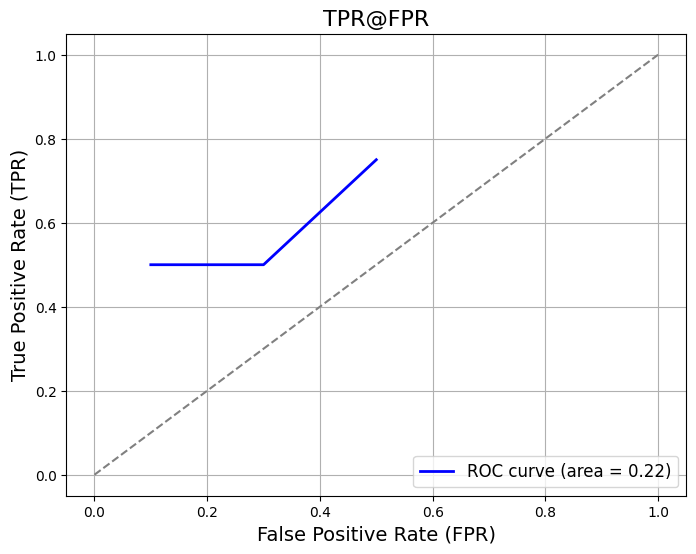

In [ ]:
#@title Plot TPR@FPR

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_tpr_fpr(tpr_range, fpr_range):
    # Plot tpr_range vs fpr_range
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_range, tpr_range, color='blue', lw=2,
             label=f'ROC curve (area = {auc(fpr_range, tpr_range):.2f})'
             )
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing

    # Title and labels
    plt.title('TPR@FPR', fontsize=16)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)

    # Display the plot
    plt.grid(True)
    plt.show()

plot_tpr_fpr(test_tpr, test_fpr)

### OML version

In [ ]:
# %%capture
# !pip install open-metric-learning

In [ ]:
# from oml.functional.metrics import calc_fnmr_at_fmr

# fpr_range = [0.5, 0.3, 0.1]

# fnmr = calc_fnmr_at_fmr(
#     test_cosine_query_pos.numpy(),
#     test_cosine_query_neg.numpy(),
#     fmr_vals=fpr_range
# )

# 1 - fnmr

## Test models using TPR @ FPR

### Step-by-step

In [ ]:
# ds_query, ds_distr = get_datasets_celeba_full_ir()
ds_query, ds_distr = get_datasets_celeba_500_ir()

dl_query, dl_distr = get_dataloaders(
    None, ds_query, ds_distr,
    batch_size=8
)

In [ ]:
#@title Compute embeddings

def compute_embeddings(model, dataloader):
    model.eval()
    embs_all = []
    device = model.device
    with torch.inference_mode():
        for imgs, lbls in tqdm(dataloader, desc="Computing embeddings"):
            embs = model(imgs.to(device))
            embs_all.append(embs.to(device))
        embs_all = torch.cat(embs_all, dim=0)
    print(f"Computed {embs_all.shape[0]} embeddings")
    return embs_all

In [ ]:
# model, model_path = load_wandb_model(
#     artifact_name='model-s9oxb2fi:v12'
# )

# query_embeddings = compute_embeddings(model, dl_query)
# distractors_embeddings = compute_embeddings(model, dl_distr)

In [ ]:
query_embeddings = torch.rand(len(dl_query.dataset))
distractors_embeddings = torch.rand(len(dl_query.dataset))

In [ ]:
cos_query_pos = compute_cosine_query_pos(
    query_embeddings,
    id_to_emb_idx=dl_query.dataset.id_to_idx
    )

cos_query_neg = compute_cosine_query_neg(
    query_embeddings,
    id_to_emb_idx=dl_query.dataset.id_to_idx
    )

cos_query_distr = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

In [ ]:
fpr_range = [0.5, 0.3, 0.1]
tpr_range = []
for fpr in fpr_range:
    thr, tpr = compute_ir(cos_query_pos, cos_query_neg, cos_query_distr, fpr=fpr)
    tpr_range.append(tpr)
    print(f"TPR={round(tpr, 2)} @ FPR={round(fpr, 2)}")

In [ ]:
# TODO: plot tpr vs fpr
results = {
    f"TPR@FPR={fpr}": round(tpr, 2)
    for fpr, tpr in zip(fpr_range, tpr_range)
    }
results = {
    ("TPR", fpr): tpr for fpr, tpr in zip(fpr_range, tpr_range)
    }
df = pd.DataFrame(results, index=[0])
df

### Define functions

In [ ]:
#@title Compute embeddings

def compute_embeddings(model, dataloader):
    model.eval()
    embs_all = []
    device = model.device
    with torch.inference_mode():
        for imgs, lbls in tqdm(dataloader, desc="Computing embeddings"):
            embs = model(imgs.to(device))
            embs_all.append(embs.to(device))
        embs_all = torch.cat(embs_all, dim=0)
    print(f"Computed {embs_all.shape[0]} embeddings")
    return embs_all

In [ ]:
#@title Test model
from time import perf_counter
from datetime import timedelta

def test_model(
        dataset_name, batch_size,

        project_name=None,
        artifact_name=None,
        use_knn_model=False,

        use_insightface_model=False,
        insightface_name='buffalo_s',

        fpr_range=[1e-1, 1e-2, 1e-3, 1e-4],
        limit_dataset=None,

        use_fnmr=False,
        verbose=True,
        **ds_getter_kwargs
        ):

    if use_insightface_model:
        assert project_name is None
        assert artifact_name is None

        model = get_insightface_model(insightface_name)
        compute_embeddings_func = compute_embeddings_insightface
    else:
        assert project_name in ['face-recognition-mbf', 'umd_faces-embeddingnet']
        assert artifact_name is not None

        # if model is None:
        model, model_path = load_wandb_model(
            project_name=project_name,
            artifact_name=artifact_name,
            use_knn_model=use_knn_model
        )

        compute_embeddings_func = compute_embeddings

    # assert \
    #     artifact_name is None and model is not None or \
    #     artifact_name is not None and model is None

    assert dataset_name in ['celeba_full', 'celeba_500']


    if dataset_name == 'celeba_full':
        ds_query, ds_distr = get_datasets_celeba_full_ir(**ds_getter_kwargs)
    elif dataset_name == 'celeba_500':
        ds_query, ds_distr = get_datasets_celeba_500_ir()


    id_to_idx = ds_query.id_to_idx
    if limit_dataset is not None:
        limit_idx = list(range(0, limit_dataset))

        ds_query = Subset(ds_query, limit_idx)
        ds_distr = Subset(ds_distr, limit_idx)

        def subset_mapping(id_to_idx):
            subset_id_to_idx = {}
            for id, idx_list in id_to_idx.items():
                for idx in idx_list:
                    subset_idx_list = list(filter(lambda idx: idx < limit_dataset, idx_list))
                subset_id_to_idx.update({id: subset_idx_list})
            return subset_id_to_idx

        id_to_idx = subset_mapping(id_to_idx)


    dl_query, dl_distr = get_dataloaders(
        ds_valid=ds_query, ds_test=ds_distr,
        batch_size=batch_size
    )

    query_embeddings = compute_embeddings_func(model, dl_query)
    distractors_embeddings = compute_embeddings_func(model, dl_distr)

    tic = perf_counter()
    cos_query_pos = compute_cosine_query_pos(
        query_embeddings,
        id_to_emb_idx=id_to_idx,
        )

    toc = perf_counter()
    print(f"Computing query positive time: {timedelta(seconds=toc-tic)}")

    tic = perf_counter()
    cos_query_neg = compute_cosine_query_neg(
        query_embeddings,
        id_to_emb_idx=id_to_idx,
        )

    toc = perf_counter()
    print(f"Computing query negative time: {timedelta(seconds=toc-tic)}")

    tic = perf_counter()
    cos_query_distr = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)
    toc = perf_counter()
    print(f"Computing query distractors time: {timedelta(seconds=toc-tic)}")

    if use_fnmr:
        fnmr_range = calc_fnmr_at_fmr(cos_query_pos.numpy(), cos_query_neg.numpy(), fmr_vals=fpr_range)
        tpr_range = 1 - fnmr_range.numpy()
        thr_range = [None] * len(fpr_range)
    else:
        tpr_range = []
        thr_range = []
        for fpr in fpr_range:
            thr, tpr = compute_ir(cos_query_pos, cos_query_neg, cos_query_distr, fpr=fpr)
            tpr_range.append(tpr)
            thr_range.append(thr)

    return tpr_range, fpr_range, thr_range, (query_embeddings, distractors_embeddings)

In [ ]:
#@title Get results

def get_test_results(tpr_range, fpr_range, thr_range,
                     loss_fn_name):

    test_results = {'loss_fn': loss_fn_name}
    test_results.update({
        f"TPR@FPR={fpr}": round(tpr, 2)
        for fpr, tpr in zip(fpr_range, tpr_range)

        # f"FPR={fpr}": {"TPR": round(tpr, 2), "threshold": round(thr, 2)}
        # for fpr, tpr, thr in zip(fpr_range, tpr_range, thr_range)
        })

    # test_results.update({'ckpt': artifact_name})
    # print(test_results)

    return test_results

In [ ]:
#@title Insightface: Get model

if torch.cuda.is_available():
    PROVIDERS = ['CUDAExecutionProvider']
else:
    PROVIDERS = ['CPUExecutionProvider']

def get_insightface_model(model_name='buffalo_sc', det_size = (112, 112)):
    app = FaceAnalysis(name=model_name, providers = PROVIDERS)
    app.prepare(ctx_id=0, det_size=det_size)
    return app

# model = get_insightface_model()

In [ ]:
#@title Insightface: Compute embeddings

def compute_embeddings_insightface(app, dataloader):
    rec_model = app.models['recognition']
    embs_all = []
    with torch.inference_mode():
        for imgs, lbls in tqdm(dataloader, desc="Computing embeddings"):
            embs = rec_model.forward(imgs.cpu().numpy())
            embs = torch.from_numpy(embs)
            embs_all.append(embs)
        embs_all = torch.cat(embs_all, dim=0)
    print(f"Computed {embs_all.shape[0]} embeddings")
    return embs_all

### Test models

In [ ]:
#@title Define testing options
IR_BATCH_SIZE = 8

testing_options_celeba_full = dict(
    dataset_name='celeba_full',
    batch_size=IR_BATCH_SIZE,
    ir_split_ratio=0.05,
    query_split_ratio=0.2,
)

testing_options_celeba_500 = dict(
    dataset_name='celeba_500',
    batch_size=IR_BATCH_SIZE,
)

#### Trained on UMDFaces-245 test on CelebA-500 IR

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: tony-pitchblack (overfit1010). Use `wandb login --relogin` to force relogin


True

In [ ]:
#@title Best softmax model
# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, _ = test_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-j3j6hd6s:v19',
    **testing_options_celeba_500
    )

softmax_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='softmax',
    )

pd.DataFrame([softmax_results])

Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.656591
Computing query negative time: 0:00:41.840338
Computing query distractors time: 0:02:07.884248


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  softmax         0.33          0.12           0.05            0.02

In [ ]:
#@title Best combined margin model
# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, embs_combined_margin = test_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-17ge273c:v30',
    **testing_options_celeba_500
    )

combined_margin_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='combined_margin',
    )

pd.DataFrame([combined_margin_results])

Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.733365
Computing query negative time: 0:00:41.326803
Computing query distractors time: 0:02:17.537918


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  combined_margin         0.39          0.15           0.06            0.03

In [ ]:
#@title Best triplet model

# Trained on UMDFaces
# Testing on CelebA-500 IR

*resulting_ranges, embs_triplet = test_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-3g71rhoc:v21',
    use_knn_model=True,
    **testing_options_celeba_500
    )

triplet_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='triplet',
    )

pd.DataFrame([triplet_results])

Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:02.429310
Computing query negative time: 0:00:35.891614
Computing query distractors time: 0:01:51.630949


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  triplet         0.37          0.14           0.06            0.03

In [ ]:
#@title Best contrastive model

# Trained on UMDFaces
# Testing on CelebA-500 IR

*resulting_ranges, embs_contrastive = test_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-xwa2jk2p:v4',
    use_knn_model=True,
    **testing_options_celeba_500
    )

contrastive_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='contrastive',
    )

pd.DataFrame([contrastive_results])

Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.929785
Computing query negative time: 0:00:34.109898
Computing query distractors time: 0:01:40.936540


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  contrastive          0.4          0.14           0.05            0.02

In [ ]:
#@title Insightface model: buffalo_s (reference)

# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, _ = test_model(
    insightface_model=True,
    insightface_name='buffalo_s',
    compute_embeddings_func = compute_embeddings_insightface,
    **testing_options_celeba_500
    )

insightface_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='insightface',
    )

pd.DataFrame([insightface_results])

Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.784631
Computing query negative time: 0:00:40.146130
Computing query distractors time: 0:03:24.291559


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  insightface          0.2          0.05           0.02            0.01

In [ ]:
#@title Insightface model: buffalo_l

# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, _ = test_model(
    insightface_model=True,
    insightface_name='buffalo_l',
    compute_embeddings_func = compute_embeddings_insightface,
    **testing_options_celeba_500
    )

insightface_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='insightface',
    )

pd.DataFrame([insightface_results])

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 82430.85KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionP

Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.598323
Computing query negative time: 0:00:29.073751
Computing query distractors time: 0:01:28.372146


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  insightface         0.15          0.03           0.01             0.0

In [ ]:
#@title Best models TPR @ FPR
test_results_df = pd.DataFrame([
    softmax_results,
    combined_margin_results,
    triplet_results,
    contrastive_results,
    ])
test_results_df

loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0          softmax         0.33          0.12           0.05            0.02
1  combined_margin         0.39          0.15           0.06            0.03
2          triplet         0.37          0.14           0.06            0.03
3      contrastive         0.40          0.14           0.05            0.02

#### Trained on CelebA (full) + tested on CelebA (full) IR

In [ ]:
#@title Alternative triplet model (CelebA full)
# Trained on CelebA (full)
# Testing on CelebA (full) IR

*resulting_ranges, embs_triplet = test_model(
    artifact_name='model-9p273v13:v9',
    **testing_options_celeba_full
    )

triplet_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='triplet',
    )

pd.DataFrame([triplet_results])

Computing embeddings:   0%|          | 0/30 [00:00<?, ?it/s]

Computed 237 embeddings


Computing embeddings:   0%|          | 0/112 [00:00<?, ?it/s]

Computed 889 embeddings
Computing query positive time: 0:00:00.158804
Computing query negative time: 0:00:00.985779
Computing query distractors time: 0:00:09.481247


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  triplet         0.81          0.52           0.31            0.16

In [ ]:
#@title Alternative contrastive model (CelebA full)
# Trained on CelebA (full)
# Testing on CelebA (full) IR

*resulting_ranges, embs_contrastive = test_model(
    artifact_name='model-s9oxb2fi:v12',
    **testing_options_celeba_full
    )

contrastive_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='contrastive',
    )

pd.DataFrame([contrastive_results])

Computing embeddings:   0%|          | 0/30 [00:00<?, ?it/s]

Computed 237 embeddings


Computing embeddings:   0%|          | 0/112 [00:00<?, ?it/s]

Computed 889 embeddings
Computing query positive time: 0:00:00.124607
Computing query negative time: 0:00:00.910339
Computing query distractors time: 0:00:08.739979


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  contrastive         0.92           0.6            0.3            0.12

In [ ]:
#@title Insightface model (CelebA full)

# Trained on CelebA (full)
# Testing on CelebA (full) IR

*resulting_ranges, embs_contrastive = test_model(
    use_insightface_model=True,
    **testing_options_celeba_full
    )

contrastive_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='insightface',
    )

pd.DataFrame([contrastive_results])

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (112, 112)


Computing embeddings:   0%|          | 0/30 [00:00<?, ?it/s]

Computed 237 embeddings


Computing embeddings:   0%|          | 0/112 [00:00<?, ?it/s]

Computed 889 embeddings
Computing query positive time: 0:00:00.165224
Computing query negative time: 0:00:01.247404
Computing query distractors time: 0:00:11.491235


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  insightface         0.19          0.05           0.02             0.0

### FNMR @ FMR

In [ ]:
#@title Best softmax model (FNMR)
# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, _ = test_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-j3j6hd6s:v19',
    use_fnmr=True,
    limit_dataset=50,
    **testing_options_celeba_500
    )

softmax_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='softmax',
    )

pd.DataFrame([softmax_results])

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.2


Computing embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Computed 50 embeddings


Computing embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Computed 50 embeddings
Computing query positive time: 0:00:00.022972
Computing query negative time: 0:00:00.090852
Computing query distractors time: 0:00:00.113430


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  softmax         0.03           0.0            0.0             0.0

In [ ]:
#@title Insightface model: buffalo_s (reference) [FNMR]

# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, _ = test_model(
    use_insightface_model=True,
    insightface_name='buffalo_s',
    use_fnmr=True,
    # limit_dataset=50,
    **testing_options_celeba_500
    )

insightface_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='insightface',
    )

pd.DataFrame([insightface_results])

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (112, 112)


Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.947070
Computing query negative time: 0:00:32.346655
Computing query distractors time: 0:01:38.752720


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  insightface         0.08          0.01            0.0             0.0

In [ ]:
#@title Insightface model: buffalo_l (reference) [FNMR]

# Trained on UMDFaces-245
# Testing on CelebA-500 IR

*resulting_ranges, _ = test_model(
    use_insightface_model=True,
    insightface_name='buffalo_l',
    use_fnmr=True,
    # limit_dataset=50,
    **testing_options_celeba_500
    )

insightface_results = get_test_results(
    *resulting_ranges,
    loss_fn_name='insightface',
    )

pd.DataFrame([insightface_results])

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:07<00:00, 37267.26KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (112, 112)


Computing embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Computed 1222 embeddings


Computing embeddings:   0%|          | 0/251 [00:00<?, ?it/s]

Computed 2001 embeddings
Computing query positive time: 0:00:00.628744
Computing query negative time: 0:00:31.758136
Computing query distractors time: 0:01:37.422339


loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0  insightface         0.09          0.01            0.0             0.0

### Upload embeddings

In [ ]:
EMB_DIR = './embeddings/'

def save_embeddings(embeddings, run_id):
    """
    params:
        embeddings: list of tensors
    """

    os.makedirs(os.path.join(EMB_DIR, run_id), exist_ok=True)
    save_path = os.path.join(EMB_DIR, run_id, 'embeddings.ckpt')
    torch.save([embs.cpu() for embs in embs_combined_margin], save_path)

    logger = WandbLogger(project="face-recognition-mbf", id=run_id, resume='must')
    artifact = wandb.Artifact('embeddings.ckpt', 'embeddings')
    logger.experiment.log_artifact(artifact)
    wandb.finish()

### Verification accuracy on LFW

In [ ]:
from torchvision.datasets import LFWPairs

MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1/255, 1/255, 1/255]), # [0, 1] -> [1, 255]
    transforms.Normalize(MEAN, STD), # [1, 255] -> [-1, 1]
])

inv_normalize = transforms.Normalize(
    mean = -np.array(MEAN) / np.array(STD),
    std = 1 / STD
)

ds_lfw = LFWPairs(root='./data', split='test', transform=transform, download=True)
dl_lfw = DataLoader(ds_lfw, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified


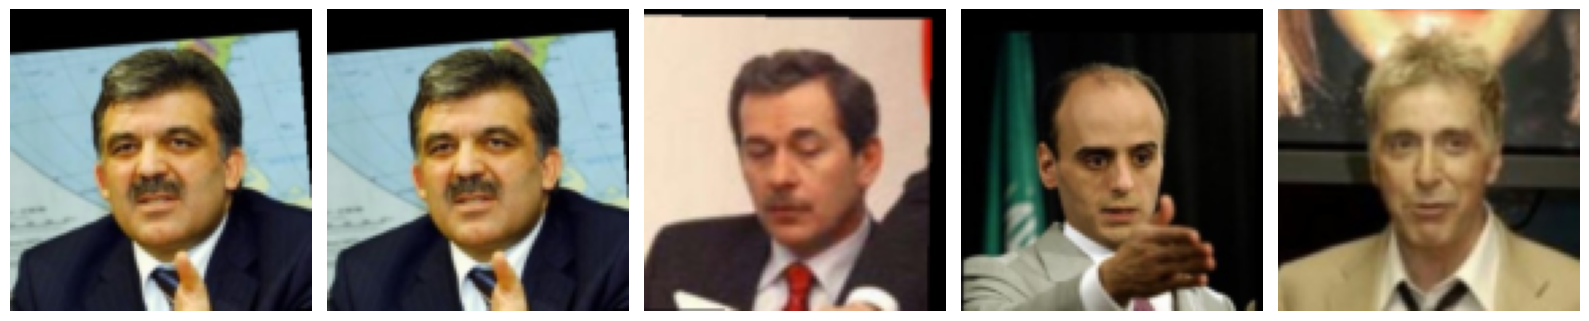

In [ ]:
imgs, *_ = next(iter(dl_lfw))
show_images(imgs, inv_normalize=inv_normalize)

In [ ]:
#@title FUNC: Evaluate
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate(model, dl_lfw, max_batches=None, insightface=False):
    if max_batches is not None:
        max_batches = int(max_batches * len(dl_lfw))
    else:
        max_batches = len(dl_lfw)

    if not insightface:
        model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (img1, img2, target) in enumerate(tqdm(dl_lfw, total=max_batches)):
            if batch_idx == max_batches:
                break

            img1, img2, target = img1.to(device), img2.to(device), target.to(device)

            if insightface:
                emb1 = model.models['recognition'].forward(img1.numpy())
                emb2 = model.models['recognition'].forward(img2.numpy())

                emb1 = torch.tensor(emb1)
                emb2 = torch.tensor(emb2)
            else:
                emb1 = model(img1)
                emb2 = model(img2)

            cos_sim = F.cosine_similarity(emb1, emb2)

            predictions = (cos_sim > 0.5).float()

            correct += (predictions == target.float()).sum().item()
            total += target.size(0)

    accuracy = correct / total
    return accuracy

In [ ]:
#@title Best softmax model

model, model_path = load_wandb_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-j3j6hd6s:v19',
    use_knn_model=False
)

accuracy = evaluate(model, dl_lfw, max_batches=0.5)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.2


  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 12.70%


In [ ]:
#@title Best Combined Margin

model, model_path = load_wandb_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-17ge273c:v30',
    use_knn_model=False
)

accuracy = evaluate(model, dl_lfw, max_batches=0.5)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.2


  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 14.65%


In [ ]:
#@title Best Triplet model

model, model_path = load_wandb_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-3g71rhoc:v21',
    use_knn_model=False
)

accuracy = evaluate(model, dl_lfw, max_batches=0.5)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 12.70%


In [ ]:
#@title Best Contrastive model

model, model_path = load_wandb_model(
    project_name='umd_faces-embeddingnet',
    artifact_name='model-xwa2jk2p:v4',
    use_knn_model=False
)

accuracy = evaluate(model, dl_lfw, max_batches=0.5)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 64.45%


In [ ]:
#@title Insightface model: buffalo_s (reference)
model = get_insightface_model(model_name='buffalo_s')

accuracy = evaluate(model, dl_lfw, max_batches=0.5, insightface=True)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (112, 112)


  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 97.66%


In [ ]:
#@title Insightface model: buffalo_l
model = get_insightface_model(model_name='buffalo_l')

accuracy = evaluate(model, dl_lfw, max_batches=0.5, insightface=True)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (112, 112)


  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 97.66%


In [ ]:
from torchvision.models import ResNet18_Weights

# Step 2: Load pre-trained model (you can replace this with your custom model)
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 128)  # Modify output for face embedding size
model.to(device)

accuracy = evaluate(model, dl_lfw, max_batches=0.5)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 97.66%


In [ ]:
# Step 2: Load pre-trained model (you can replace this with your custom model)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 128)  # Modify output for face embedding size
model.to(device)

# Step 9: Perform evaluation
accuracy = evaluate(model, dl_lfw, max_batches=0.5)
print(f'Model accuracy on LFWPairs: {accuracy * 100:.2f}%')

  0%|          | 0/16 [00:00<?, ?it/s]

Model accuracy on LFWPairs: 97.66%


In [ ]:
!ls {ROOT_DATA_DIR}

celeba	celebA_ir  lfw-py  __MACOSX


## Verification Accuracy on CFP-FP (TODO)

In [ ]:
from pathlib import Path

zip_path = Path(ROOT_SAVE_DIR) / 'cfp-dataset.zip'
!unzip -qn {zip_path} -d {ROOT_DATA_DIR}

In [ ]:
DATA_DIR_CFP = Path(ROOT_DATA_DIR) / 'cfp-dataset'
!ls {DATA_DIR_CFP / 'Protocol'}

Pair_list_F.txt  Pair_list_P.txt  Split


In [ ]:
df_pairs_f = pd.read_csv(
    DATA_DIR_CFP / 'Protocol' / 'Pair_list_F.txt',
    header=0, names=['pair', 'path'], sep=' ',
)

df_pairs_f.head(20)

pair                               path
0      2  ../Data/Images/001/frontal/02.jpg
1      3  ../Data/Images/001/frontal/03.jpg
2      4  ../Data/Images/001/frontal/04.jpg
3      5  ../Data/Images/001/frontal/05.jpg
4      6  ../Data/Images/001/frontal/06.jpg
5      7  ../Data/Images/001/frontal/07.jpg
6      8  ../Data/Images/001/frontal/08.jpg
7      9  ../Data/Images/001/frontal/09.jpg
8     10  ../Data/Images/001/frontal/10.jpg
9     11  ../Data/Images/002/frontal/01.jpg
10    12  ../Data/Images/002/frontal/02.jpg
11    13  ../Data/Images/002/frontal/03.jpg
12    14  ../Data/Images/002/frontal/04.jpg
13    15  ../Data/Images/002/frontal/05.jpg
14    16  ../Data/Images/002/frontal/06.jpg
15    17  ../Data/Images/002/frontal/07.jpg
16    18  ../Data/Images/002/frontal/08.jpg
17    19  ../Data/Images/002/frontal/09.jpg
18    20  ../Data/Images/002/frontal/10.jpg
19    21  ../Data/Images/003/frontal/01.jpg

## Отчет

### Настройки эксперимента

**Параметры модели**

Модель MobileFaceNet обучалась по изображениям лиц размера 112x112 выдавать эмбеддинги размера 128.

**Данные**

Было использовано три сабсета из двух датасетов CelebA (200k изображений, 10k id) и UMDFaces (360k изображений, 8k id всего):
- CelebA-full (100k изображений, ??? id)
- CelebA-500 (12k изображений, 500 id)
- UMDFaces-245 (16k изображений, 245 id)


*Примечание 1:* Celeba-full сабсет создавался на основе оригинальных train/val/test сплитов CelebA, доступных в torchvision, в каждом из которых содержатся изображения людей, которых нет в остальных сплитах. Для CelebaA-500 и UMDFaces-245 было гаранировано, что для каждого ID есть хотя бы одно изображение в каждом из train/val/test сплитов для того, чтобы можно было корректно считать лоссы Softmax и Arcface, а также Accuaracy.

*Примечание 2:* Эксперименты для CelebA-500 и UMDFaces-245 проводились [в отдельном ноутбуке](https://colab.research.google.com/drive/1m6RkDXnwaVahdN29shyD8-LjOIBkuN7H?usp=sharing)

К изображениям применялись следующие аугментации:
1. Crop:
    - Размер 112x112

    или

    - Размер 96x112 + дополнить сплошным фоном до квадрата с помощью SquarePad (не использовался)

2. RandomHorizontalFlip:
    - Только для train сплита для каждого датасета.

3. RandomPhotometricDistort:
    - Только для train плита CelebA (full).

4. Normalize:
    - Для CelebA (full) изображения нормализовывались с помощью среднего и стандартного отклонения ImageNet.
    - Для CelebA-500 и UMDFaces нормализация производилась для приведения значений из диапазона [0;255] в диапазон [-1;1] путем вычитания 127.5 и деления на 128. Так же было сделано в статьях ArcFace и MobileFaceNet.

**Общие замечания**

Оптимизатор, шедулер и параметры лосс-функций для  Softmax и CombinedMargin подбирались опираясь на статьи
[ArcFace](https://arxiv.org/pdf/1801.07698) и [MobileFaceNet](https://arxiv.org/pdf/1804.07573).

Параметры лосс-функций Triplet и Contrastive выбирались согласно статьям [FaceNet](https://www.arxiv.org/pdf/1503.03832) и [Supervised Contrastive Learning](https://arxiv.org/pdf/2004.11362), но так как использорванные в статьях датасеты и модели оказались несопоставимыми по размерам с текущим экспериментом, оптимизатор и шедулер использовались такие же как для первых двух лосс-функций.



**Оптимизатор**

    SGD (
        lr = 0.1
        weight decay = 4e-5,
        momentum = 0.9
    )

**Шедулер**

Эпохи уменьшения `learning rate` подбирались относительно самых сопоставимых по количеству изображений датасетов.
Самые маленькие датасеты использованные в упомянутых исследованиях - iBUG-500k и CASIA-Webface, оба из которых содержат примерно 0.5 миллиона изображений, в то время как датасет CelebA, использованный в текущей работе, содержит меньшее количество изображений - 0.2 миллиона.

    MultiStepLR(
        gamma = 0.1,

        # iBUG @ 18 epochs
        milestones = [8, 14],

        или
        
        # CASIA @ 32 epochs
        milestones =  [18, 26, 28]
    )



**Гиперпараметры Combined Margin loss**

Угловой софтмакс с зазором был настроен как смеcь SphereFace и ArcFace (без CosFace)

    CombinedMarginLoss (
        s = 32
        m_1 = 1.0, m_2 = 0.5, m_3 = 0
    )
*Примечание:* Эти параметры используемые по умолчанию в InsightFace. Они немного отличаются от использованных в статье ArcFace. В таблице ниже приведены оригинальные значения зазоров.

image.png

**Особенности обучения Triplet loss и Supervised Contrastive loss**

Гиперпараметры были выбраны согласно вышеупомянутым статьям.

    TripletLoss(
        margin = 0.2
    )

    SupervisedContrastiveLoss(
        temperature = 0.1
    )

*Примечание:* мною написанная функция для Supervised Contasive Loss не запускалась на GPU с float16 mixed precision training, несмотря на то что выход функции совпадал с выходом функции написанной авторами. Это было сложно отдебажить, поэтому я просто использовал функцию авторов (MultiPosConLoss)

Для обучения с помощью обоих лоссов был использован кастомный сэмплер, который обладает следующими свойствами:

1. В каждом батче размера $B$ присутствуют изображения ровно для $P$ персон, по $K$ изображений на каждого. При этом если в процессе формирования очередного батча для какой-либо персоны остается меньше $K$ изображений, они не используются.

    *Примечание:* оставшиеся изображения можно использовать, просто этот функционал не был реализован.

2. Выбор изображений для каждого батча происходит без повторений - каждое изображение в датасете либо используется единожды, либо не используется (так как невозможного сформировать батч с заданными параметрами)

*Примечание:* сэмплер формирует индексы для всех батчей в начале каждой эпохи.

Для Triplet loss для сэмплера использовалось количество персон $P=2$, что соответствует одному positive на один anchor.

Также для Triplet loss использовалось была использована стратегия Batch Hardest, для реализации которой был адаптирован код на TensorFlow из [блога](https://omoindrot.github.io/triplet-loss#triplet-mining).

Для Contrastive Loss hard sample mining не использовался, так как в статье [Supervised Contrastive Learning, пагарграф 3.2.2](https://arxiv.org/pdf/2004.11362) показано, что представленная функция потерь обладает эитм свойством сама по себе (has the intrinsic ability to perform hard positive/negative mining).

### Результаты обучения

Обучение моделей на наборах данных UMDFaces-245 и CelebA-500 производилось [в отдельном ноутбуке](https://colab.research.google.com/drive/1m6RkDXnwaVahdN29shyD8-LjOIBkuN7H?usp=sharing). Подробно эксперименты описаны в [отчете Wandb](https://api.wandb.ai/links/overfit1010/12oyawbw).



Для лоссов **Softmax** и **CombinedMargin** не удалось обучить модель на наборе данных CelebA (full) из-за неверного деления на train/val/test (см. описание выше), однако получилось обучить модель с этими лоссами на UMDFaces-245. Ниже приводятся графики лоссов и Accuracy (для лоссов Triplet и Contrastive приведены графики для классификаторов поверх замороженной модели эмбеддингов)



Для Softmax Loss удалось достичь точности 0.8 при минимальной конфигурации модели [1, 1, 1, 1]

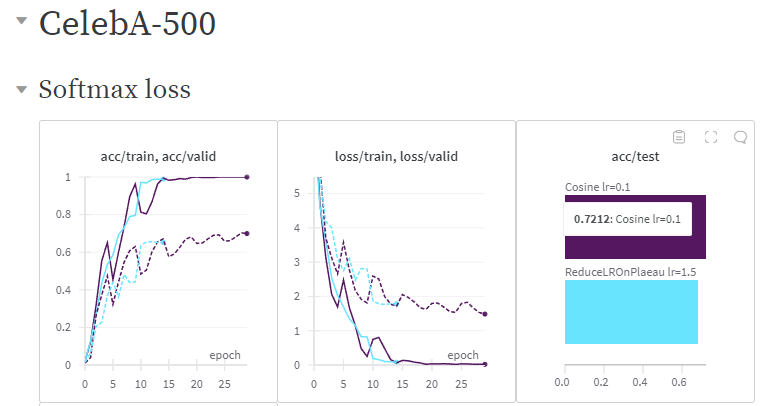

Для лосса Combined Margin получилось достичь точности 0.73 при средней конфигурации [1, 4, 6, 2]

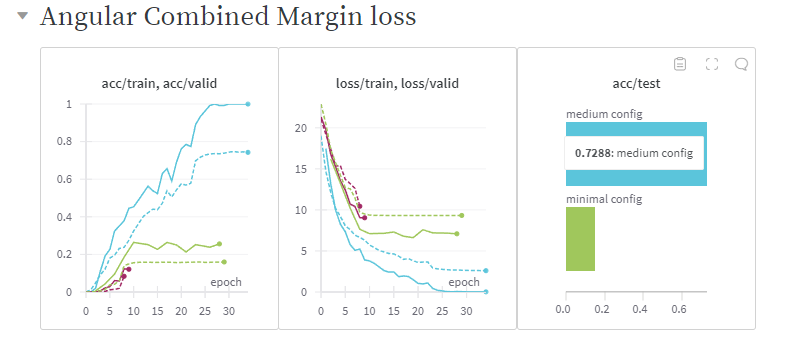

Для оценки Accuracy моделей с лоссами Triplet и Contrastive после тренировки моделей дополнительно был обучен слой классификации.

*Примечание:* На валидации была попытка использовать точность классификатора knn, однако подобрать такие гиперпараметры, чтобы оценка точности knn коррелировала с Accuracy не удалось.

Для лосса Triplet удалось достичь точности 0.86 с конфигурацией модели [1, 4, 6, 2]

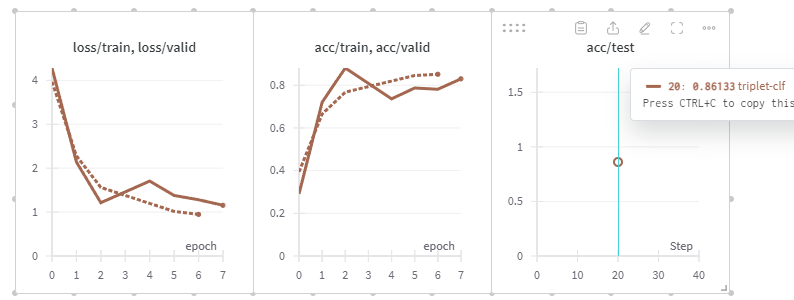

Для лосса Supervised Contrastive удалось достичь точности 0.86 с конфигурацией модели [1, 4, 6, 2]

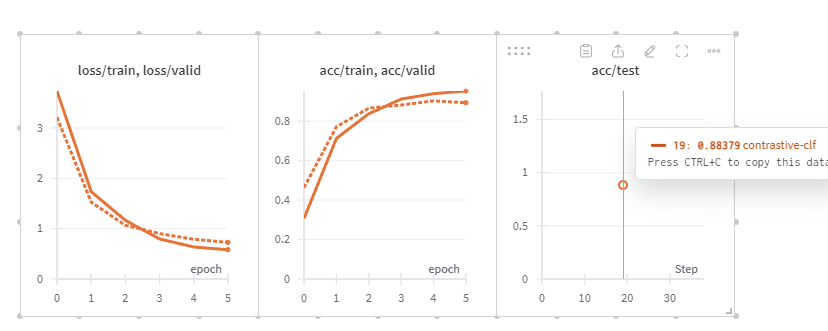

### Тестирование лучших моделей

Для всех моделей, обученных на сабсете UMDFaces-245 была рассчитана метрика TPR @ FPR на IR сплите сабсета CelebA-500 для различных значений FPR (приведены в таблице ниже). Для каждого фиксированного уровня FPR различие в точности всех моделей оказалось незначительным, причем softmax loss в среднем показал результат хуже остальных, хотя отстает ненамного. Предполагается, что при большем количестве обучающих данных остальные лосс-функции, лучше разделяющие признаки, должны показать ещё более существенный прирост точности по сравнению с softmax loss.

In [ ]:
#@title Best models TPR @ FPR
test_results_df = pd.DataFrame([
    softmax_results,
    combined_margin_results,
    triplet_results,
    contrastive_results,
    ])
test_results_df

loss_fn  TPR@FPR=0.1  TPR@FPR=0.01  TPR@FPR=0.001  TPR@FPR=0.0001
0          softmax         0.33          0.12           0.05            0.02
1  combined_margin         0.39          0.15           0.06            0.03
2          triplet         0.37          0.14           0.06            0.03
3      contrastive         0.40          0.14           0.05            0.02

# Convert best model to ONNX

## Convert

In [ ]:
artifact_name = 'model-s9oxb2fi:v12'
model, model_path = load_wandb_model(
    artifact_name=artifact_name
)

In [ ]:
import torch
import torch.onnx

# Step 2: Create a dummy input tensor with the same shape as your model input
dummy_input = torch.randn(1, 3, 112, 112)  # Example for a model expecting (batch_size, channels, height, width)

# Step 3: Export the model
onnx_path = os.path.join("models", artifact_name, "model.onnx")
torch.onnx.export(model.backbone, dummy_input, onnx_path,
                  export_params=True,        # Store the trained parameter weights inside the model file
                  opset_version=11,          # ONNX version to export to
                  do_constant_folding=True,  # Whether to execute constant folding for optimization
                  input_names=['data'],     # The model's input names
                  output_names=['output'],   # The model's output names
                  dynamic_axes={'data': {0: 'batch_size'},    # Variable length axes
                                'output': {0: 'batch_size'}},
                  keep_initializers_as_inputs=False,
                  verbose=False)


(None,)

## Sanity check

In [ ]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(name='buffalo_s', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))
img = ins_get_image('t1')
faces = app.get(img)
rimg = app.draw_on(img, faces)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [ ]:
face_rec_model = insightface.model_zoo.get_model(onnx_path)
face_rec_model.prepare(ctx_id=0)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


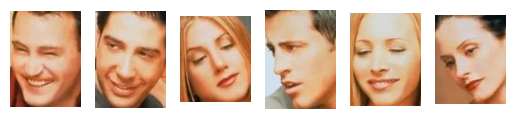

In [ ]:
to_rgb = lambda image: cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(img)
faces_list = []
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    x1, y1, x2, y2 = face.bbox.astype(int)
    face_img = img[y1:y2, x1:x2, :]
    face_img = to_rgb(face_img)
    faces_list.append(face_img)
    ax.imshow(face_img)
    ax.axis('off')

plt.show()

In [ ]:
face_rec_model.get_feat(faces_list).shape

(6, 128)

## Upload onnx model

In [ ]:
# TODO: fix save as type=model

run_id = 's9oxb2fi'
logger = WandbLogger(project="face-recognition-mbf", id=run_id, resume='must')
artifact_onnx = wandb.Artifact('model.onnx', 'model')
logger.experiment.log_artifact(onnx_path, aliases=['onnx'])
wandb.finish()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


# Explore embedding space

In [ ]:
!pip -q install umap-learn

## Пространство эмбеддингов лучшей модели

In [ ]:
model_dict = {
    'model_supcon_celeba-full_best': dict(
        artifact_name='model-s9oxb2fi:v12',
        project_name='face-recognition-mbf',
    )
}

model_best, _ = load_wandb_model(
    **model_dict['model_supcon_celeba-full_best']
)

In [ ]:
ds = CelebA('data', transform=transform_train, target_type='identity', split='test', download=True)

Files already downloaded and verified


In [ ]:
sample_images.min()

tensor(-0.9961)

In [ ]:
inv_normalize

Normalize(mean=[-0.99609375, -0.99609375, -0.99609375], std=[0.0078125, 0.0078125, 0.0078125], inplace=False)

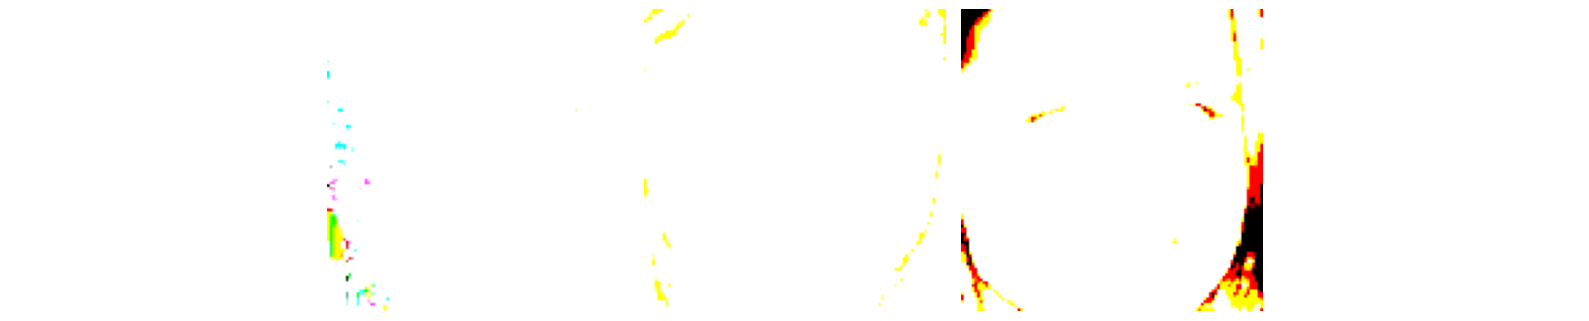

In [ ]:
torch.manual_seed(GLOBAL_SEED)
dl = get_dataloaders(ds_test=ds, batch_size=8)

sample_images, _ = next(iter(dl))
show_images(sample_images, inv_normalize=inv_normalize)

In [ ]:
#@title Compute embeddings

def compute_embeddings(model, dataloader):
    model.eval()
    embs_all = []
    device = model.device
    with torch.inference_mode():
        for imgs, lbls in tqdm(dataloader, desc="Computing embeddings"):
            embs = model(imgs.to(device))
            embs_all.append(embs.to(device))
        embs_all = torch.cat(embs_all, dim=0)
    print(f"Computed {embs_all.shape[0]} embeddings")
    return embs_all

In [ ]:
embs_sample = compute_embeddings(model_best, ds)

Computing embeddings:   0%|          | 0/19962 [00:00<?, ?it/s]

ValueError: expected 4D input (got 3D input)

## Форма пространства эмбеддингов (UMDFaces-245 models)

Сравним эмбеддинги контрастного лосса и углового софтмакса.

In [ ]:
ds_query, ds_distr = get_datasets_celeba_500_ir()
labels_500 = ds_query.labels.numpy()

ds_query, ds_distr = get_datasets_celeba_full_ir()
labels_full = ds_query.dataset.indices
labels_500.shape, labels_full.shape

((1222,), (92,))

In [ ]:
# embs_contrastive_np = torch.cat([embs_contrastive[0], embs_contrastive[1]]).cpu().numpy()
embs_contrastive_np = embs_contrastive[0].cpu().numpy()
embs_contrastive_np.shape

(1222, 128)

In [ ]:
# embs_combined_margin_np = torch.cat([embs_combined_margin[0], embs_combined_margin[1]]).cpu().numpy()
embs_combined_margin_np = embs_combined_margin[0].cpu().numpy()
embs_combined_margin_np.shape

(1222, 128)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import umap

random_state = None

# Normalize embeddings
norms = np.linalg.norm(embs_contrastive_np, axis=1, keepdims=True)
normalized_embs_contrastive_np = embs_contrastive_np / norms

norms = np.linalg.norm(embs_combined_margin_np, axis=1, keepdims=True)
normalized_embs_combined_margin_np = embs_combined_margin_np / norms

# Step 2: Standardize the data
scaler = StandardScaler()
std_embs_contrastive_np = scaler.fit_transform(normalized_embs_contrastive_np)

scaler = StandardScaler()
std_embs_combined_margin_np = scaler.fit_transform(normalized_embs_combined_margin_np)

# Project to 2D using UMAP
reducer = umap.UMAP(n_components=2, random_state=random_state)
data_contrastive = reducer.fit_transform(std_embs_contrastive_np)

reducer = umap.UMAP(n_components=2, random_state=random_state)
data_combined_margin = reducer.fit_transform(std_embs_combined_margin_np)

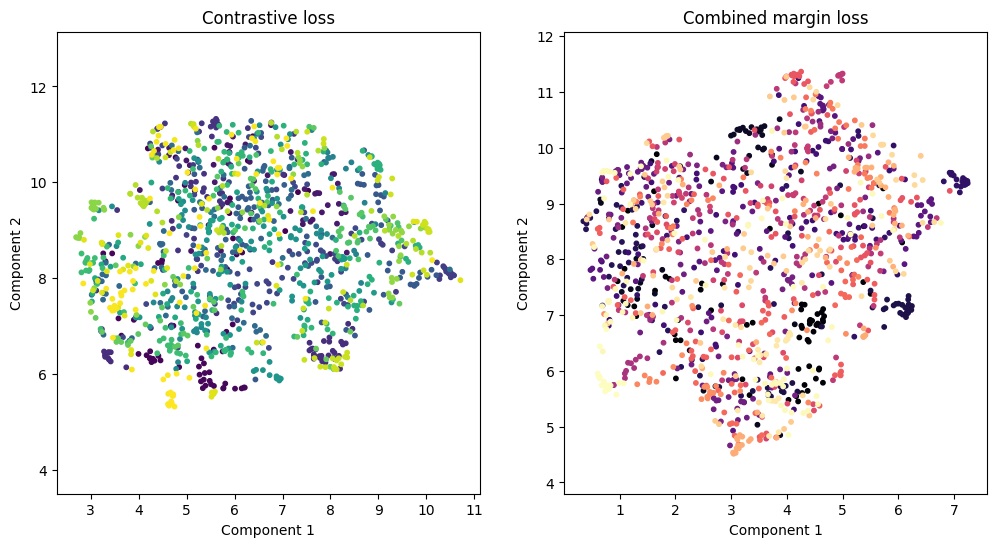

In [ ]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the results
axs[0].scatter(data_contrastive[:, 0], data_contrastive[:, 1], c=labels_500, cmap='viridis', s=10)
# axs[0].scatter(data_contrastive[:, 0], data_contrastive[:, 1], c='blue', s=10)
axs[0].set_title('Contrastive loss')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].axis('equal')


# Plot the results
axs[1].scatter(data_combined_margin[:, 0], data_combined_margin[:, 1], c=labels_500, cmap='magma',s=10)
# axs[1].scatter(data_combined_margin[:, 0], data_combined_margin[:, 1], c='red', s=10)
axs[1].set_title('Combined margin loss')
axs[1].set_xlabel('Component 1')
axs[1].set_ylabel('Component 2')
axs[1].axis('equal')

plt.show()

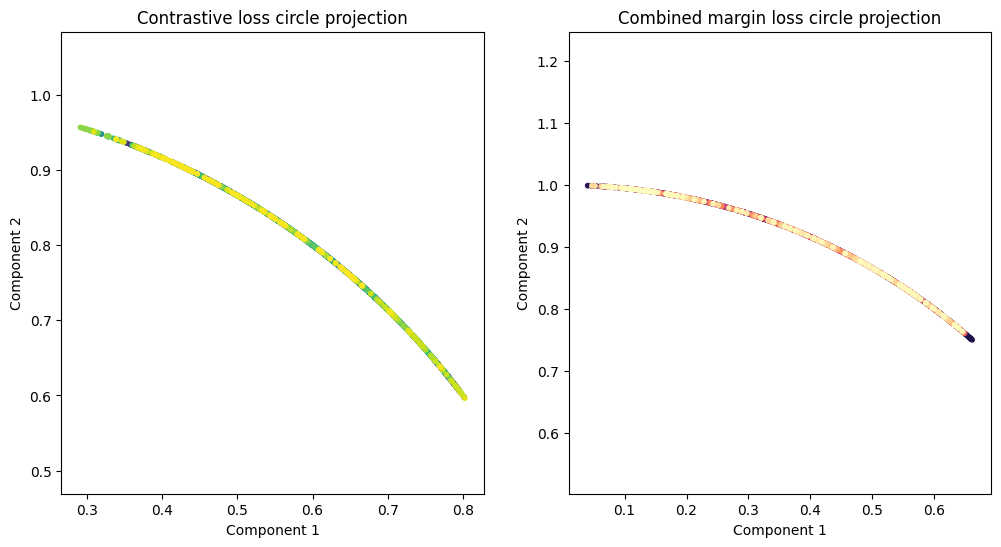

In [ ]:
# Project onto circle
radius = 1
data_contrastive_angles = np.arctan2(data_contrastive[:, 1], data_contrastive[:, 0])
data_contrastive_circle = np.column_stack((radius * np.cos(data_contrastive_angles),
                                           radius * np.sin(data_contrastive_angles)))

data_combined_margin_angles = np.arctan2(data_combined_margin[:, 1], data_combined_margin[:, 0])
data_combined_margin_circle = np.column_stack((radius * np.cos(data_combined_margin_angles),
                                           radius * np.sin(data_combined_margin_angles)))
# Plot the results projected onto circle
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the results
axs[0].scatter(data_contrastive_circle[:, 0], data_contrastive_circle[:, 1], c=labels_500, s=10)
# axs[0].scatter(data_contrastive_circle[:, 0], data_contrastive_circle[:, 1], c='blue', s=10)
axs[0].set_title('Contrastive loss circle projection')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].axis('equal')


# Plot the results
axs[1].scatter(data_combined_margin_circle[:, 0], data_combined_margin_circle[:, 1], c=labels_500, cmap='magma', s=10)
# axs[1].scatter(data_combined_margin_circle[:, 0], data_combined_margin_circle[:, 1], c='red', s=10)
axs[1].set_title('Combined margin loss circle projection')
axs[1].set_xlabel('Component 1')
axs[1].set_ylabel('Component 2')
axs[1].axis('equal')

plt.show()

## Эмбеддинги аутлаеров

### Эмбеддинги искаженных фотографий

In [ ]:
import torch
import torchvision.transforms.v2 as transforms

class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = torch.ones((h, w), dtype=torch.bool)

        for _ in range(self.n_holes):
            y = torch.randint(0, h - self.length, (1,))
            x = torch.randint(0, w - self.length, (1,))
            mask[y:y+self.length, x:x+self.length] = 0

        img = img * mask.unsqueeze(0).float()
        return img

In [ ]:
CROP_TRANSFORM = square_crop
RESCALE_SIZE = 112

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

common_transforms = [
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    *CROP_TRANSFORM,
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Normalize(MEAN, STD)
]

transform_cutout = transforms.Compose([
    *common_transforms,
    Cutout(n_holes=1, length=64),
])

In [ ]:
ds_cutout = CelebA('data', transform=transform_cutout, target_type='identity',
                   split='test', download=True)

Files already downloaded and verified


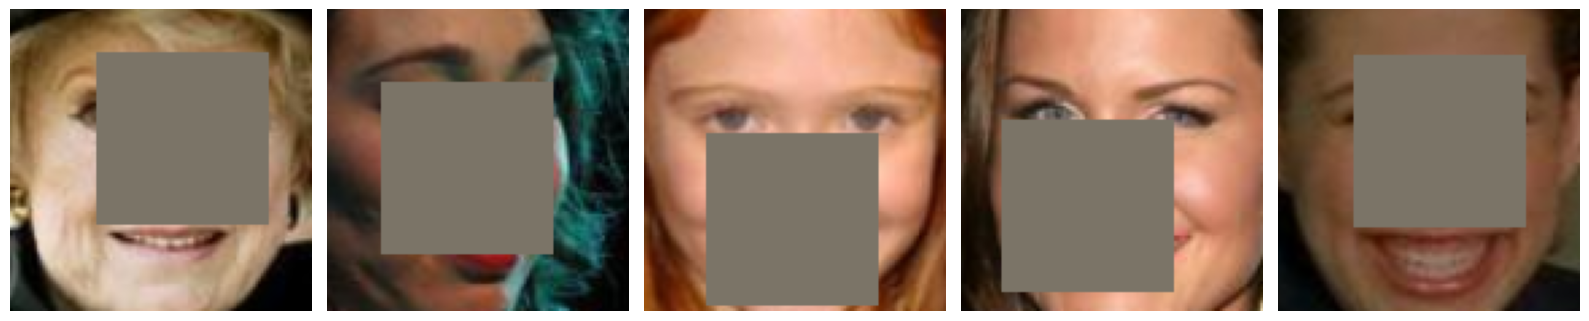

In [ ]:
torch.manual_seed(GLOBAL_SEED)
dl_cutout = get_dataloaders(ds_test=ds_cutout, batch_size=5)

sample_images, _ = next(iter(dl_cutout))
show_images(sample_images)

In [ ]:
transform_blur = transforms.Compose([
    *common_transforms,
    transforms.GaussianBlur(kernel_size=15, sigma=4.0)
])

In [ ]:
ds_blur = CelebA('data', transform=transform_blur, target_type='identity',
                 split='test', download=True)

Files already downloaded and verified


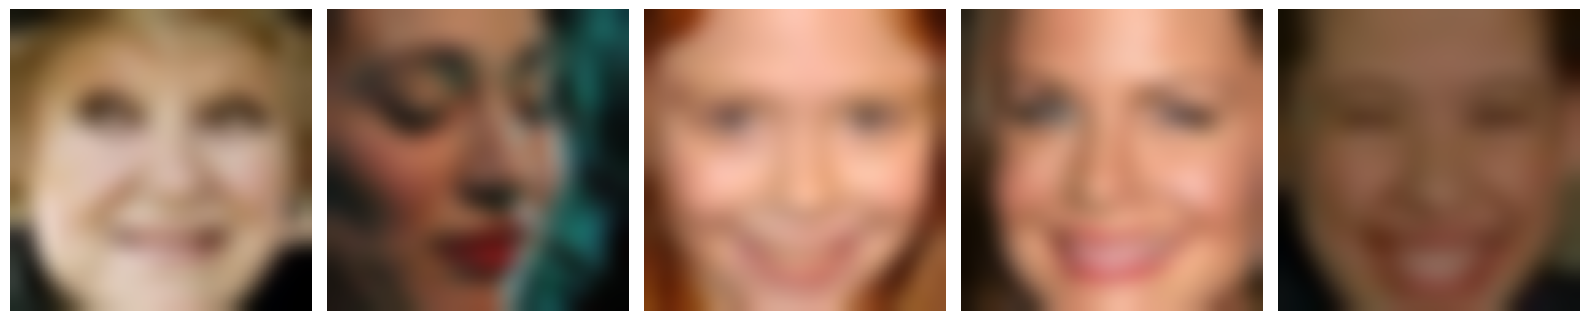

In [ ]:
torch.manual_seed(GLOBAL_SEED)
dl_blur = get_dataloaders(ds_test=ds_blur, batch_size=5)

sample_images, _ = next(iter(dl_blur))
show_images(sample_images)

In [ ]:
best_model, best_model_path = load_wandb_model(
    artifact_name='model-s9oxb2fi:v12',
)

In [ ]:
def subset_by_fraction(ds, frac):
    N = len(ds_cutout)
    K = int(N * frac)
    indices = np.arange(N)[:K]
    print(f"Total subset len: {K}")
    return Subset(ds, indices)

FRAC = 0.02
ds_blur_small = subset_by_fraction(ds_blur, FRAC)
ds_cutout_small = subset_by_fraction(ds_cutout, FRAC)

Total subset len: 399
Total subset len: 399


In [ ]:
dl_cutout = get_dataloaders(ds_test=ds_cutout_small, batch_size=64)
embs_cutout = compute_embeddings(best_model, dl_cutout)

Computing embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Computed 399 embeddings


In [ ]:
dl_blur = get_dataloaders(ds_test=ds_blur_small, batch_size=64)
embs_blur = compute_embeddings(best_model, dl_blur)

Computing embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

Computed 399 embeddings


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import umap

# Project the data into 2D using UMAP
reducer = umap.UMAP()
data_2d = reducer.fit_transform(embs_contrastive_np)
data_2d_cutout = reducer.transform(embs_cutout.cpu().numpy())
data_2d_blur = reducer.transform(embs_blur.cpu().numpy())

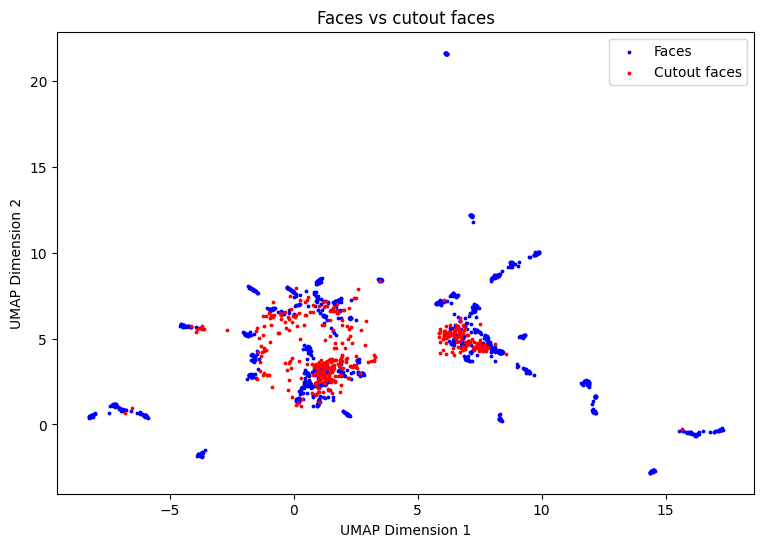

In [ ]:
dot_size = 3
plt.figure(figsize=(9, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', label='Faces', s=dot_size)
plt.scatter(data_2d_cutout[:, 0], data_2d_cutout[:, 1], c='red', label='Cutout faces', s=dot_size)
plt.legend()
plt.title('Faces vs cutout faces')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

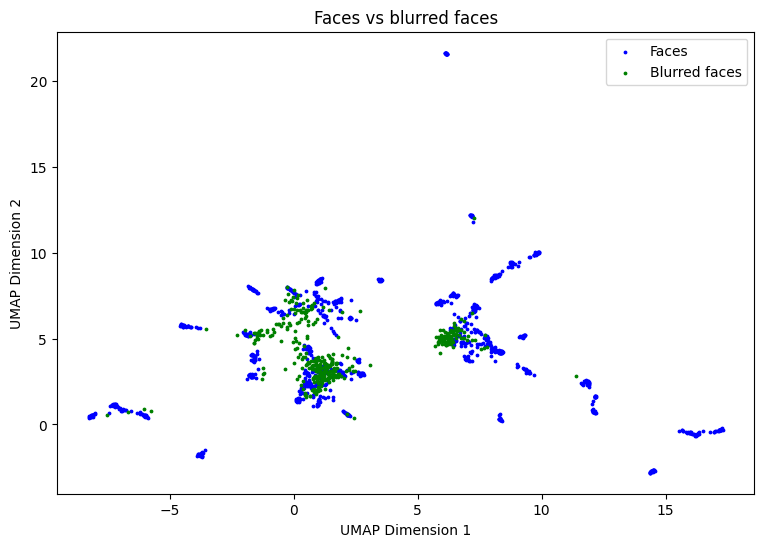

In [ ]:
dot_size = 3
plt.figure(figsize=(9, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', label='Faces', s=dot_size)
plt.scatter(data_2d_blur[:, 0], data_2d_blur[:, 1], c='green', label='Blurred faces', s=dot_size)
plt.legend()
plt.title('Faces vs blurred faces')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## Эмбеддинги не лиц

In [ ]:
import torchvision

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to tensors
    transforms.Resize((112, 112)),
    transforms.Normalize(MEAN, STD)  # Normalize with mean and std of CIFAR-10
])

ds_places = torchvision.datasets.Places365(
    root='./data/places',
    split='val',
    small=True,
    download=False,
    transform=transform
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


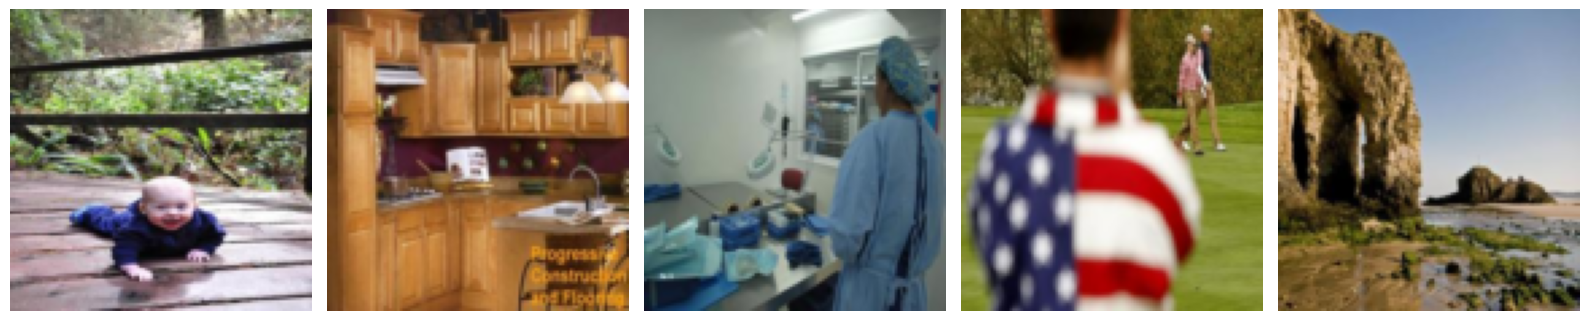

In [ ]:
torch.manual_seed(GLOBAL_SEED)
dl_places = get_dataloaders(ds_test=ds_places, batch_size=5)

sample_images, _ = next(iter(dl_places))
show_images(sample_images)

In [ ]:
ds_places_small = subset_by_fraction(ds_places, 0.05)
dl_places = get_dataloaders(ds_test=ds_places_small, batch_size=64)
embs_places = compute_embeddings(best_model, dl_places)
data_2d_places = reducer.transform(embs_places.cpu().numpy())

Total subset len: 998


Computing embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

Computed 998 embeddings


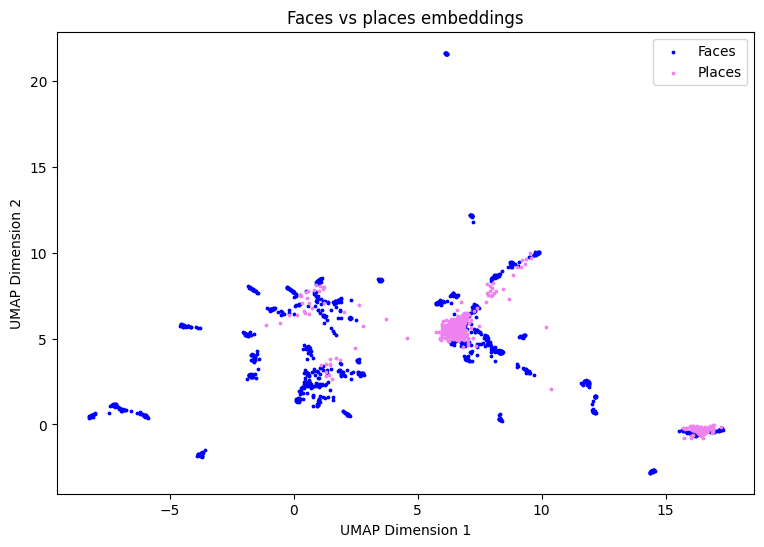

In [ ]:
dot_size=3
plt.figure(figsize=(9, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', label='Faces', s=dot_size)
plt.scatter(data_2d_places[:, 0], data_2d_places[:, 1], c='violet', label='Places', s=dot_size)
plt.legend()
plt.title('Faces vs places embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

### Вывод

Модель учится проецировать признаки в векторное пространство с определенной структурой, причем вне зависимости от того, что подается на вход модели, она выдает векторные представления из этого векторного пространства с заданной структурой. Иными словами, эмбеддинги произвольных изображений находятся рядом с эмбеддингами изображений лиц потому что модель считает любое изображение на входе лицом.

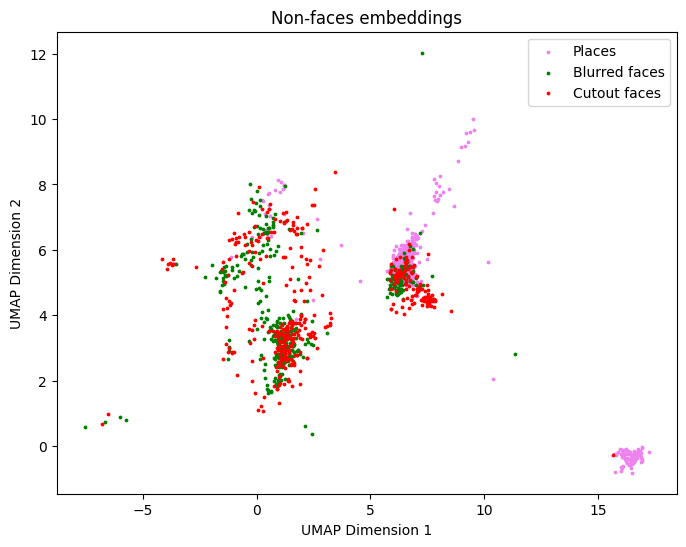

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_2d_places[:, 0], data_2d_places[:, 1], c='violet', label='Places', s=dot_size)
plt.scatter(data_2d_blur[:, 0], data_2d_blur[:, 1], c='green', label='Blurred faces', s=dot_size)
plt.scatter(data_2d_cutout[:, 0], data_2d_cutout[:, 1], c='red', label='Cutout faces', s=dot_size)
plt.legend()
plt.title('Non-faces embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()